In [25]:
# imports

import datetime
import math
import random
import searchtweets
import numpy as np
import pandas as pd
import string
import warnings
import datetime
warnings.filterwarnings('ignore')
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.tokenize import word_tokenize
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk import FreqDist
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
from IPython.display import display

[nltk_data] Downloading package stopwords to /home/keras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/keras/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to /home/keras/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/keras/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/keras/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
curated_list = ['AwkwardRambler','AngryBlackN8V',
             'Pandabbadon', 'LammaticHama','DeadDogLake',
             'cricketcrocker','devilishgrin000','LowArctic',
             'ChelseyMooner','akayatuk','nativeopinion',
             'BadSalishHeart','joyem_braun','RuthH_Hopkins',
             'brettachapman','NativeApprops','Pam_Palmater',
             'AzieDee','BigIndianGyasi','RoanhorseBex',
             'Leave_Matoaka','ZoeSTodd',
             'notvanishing','Dallas_Hunt','justicedanielh',
             'WordsandGuitar','tuckeve','tagaq',
             'TanyaTalaga','Hayden_King','gindaanis',
             'antalalakam','dearnonnatives','VinceSchilling',
             'DelSchilling','LowaBeebe',
             'llewellynjobs','DaveAlexRoberts','SaltyLilOjibwe',
             'DarrylLeroux','mredshirtshaw','mors_lakota',
             'Ruth4Nd','Indigenia','ItazipcoLakota',
             'ryanredcorn','KimTallBear','tanayawinder',
             'shotheekwe','msimmons444','powhatannative',
             'aliwatson117','jfkeeler','ThunderingElks',
             'FrankWaln','AgentNdn','DeLesslin']

In [3]:
print(len(curated_list)) 

57


In [6]:
# @justicedanielh, @KimTallBear on curated list also

I_scholars_list = ['justicedanielh', 'PepePierce', 'pollysgdaughter', 'rebeccanagle', 'KimTallBear']

In [7]:
# need to get historical tweets from curated list & scholars
# might as well do it all at once

full_list = ['AwkwardRambler','AngryBlackN8V',
             'Pandabbadon', 'LammaticHama','DeadDogLake',
             'cricketcrocker','devilishgrin000','LowArctic',
             'ChelseyMooner','akayatuk','nativeopinion',
             'BadSalishHeart','joyem_braun','RuthH_Hopkins',
             'brettachapman','NativeApprops','Pam_Palmater',
             'AzieDee','BigIndianGyasi','RoanhorseBex',
             'Leave_Matoaka','ZoeSTodd',
             'notvanishing','Dallas_Hunt','justicedanielh',
             'WordsandGuitar','tuckeve','tagaq',
             'TanyaTalaga','Hayden_King','gindaanis',
             'antalalakam','dearnonnatives','VinceSchilling',
             'DelSchilling','LowaBeebe',
             'llewellynjobs','DaveAlexRoberts','SaltyLilOjibwe',
             'DarrylLeroux','mredshirtshaw','mors_lakota',
             'Ruth4Nd','Indigenia','ItazipcoLakota',
             'ryanredcorn','KimTallBear','tanayawinder',
             'shotheekwe','msimmons444','powhatannative',
             'aliwatson117','jfkeeler','ThunderingElks',
             'FrankWaln','AgentNdn','DeLesslin',
             'PepePierce','pollysgdaughter','rebeccanagle']

In [6]:
print(len(full_list))

60


In [19]:
# version w error handling:

def get_tweet_object(search_term, start_date, end_date, num_of_tweets, include_retweets=True):
    
    '''
    takes:
    
    * date range
    * screen name
    * number of tweets to return (500 per page)
       
    input search term as a string
    
    input search range as datetime.datetime(20xx, 1, 20)
    
    include_retweets defaults is True. to exclude retweets set to False.
    
    returns: 
    
    * tweets object with replies to input screen name 
   
    '''
    
    
    search_args = searchtweets.load_credentials('twitter_keys.yaml',
                                                yaml_key='search_tweets_api',
                                                env_overwrite=False)
    
    if include_retweets:
        
        #search_term = search_term + ' lang:en'
        
        search_term = '(to:' + search_term + ') is:reply lang:en'
    
    else:
        
        #search_term = search_term + ' lang:en -is:retweet'
        
        search_term = '(to:' + search_term + ') is:reply lang:en -is:retweet'
        
    
    
    rule = searchtweets.gen_rule_payload(search_term,
                                         results_per_call=500,
                                         from_date=start_date.strftime('%Y-%m-%d'),
                                         to_date=end_date.strftime('%Y-%m-%d'))     
        
    tweet_objects = []
    
    rs = searchtweets.ResultStream(rule_payload=rule,
                                   max_results=num_of_tweets,
                                   max_pages=math.ceil(num_of_tweets / 500.0),
                                   **search_args)
    
    start_time = time.time()
    
    # error handling & rate limiting for requests
    
    try:
        
        # generator 

        for i, tweet_object in enumerate(rs.stream(), start=1):
            
            # check every 500 requests, ie every page
        
            if i % 500 == 0:
            
                now = time.time()
                
                # four second delay
            
                if now < start_time + 4:
                
                    time.sleep(4 - (now - start_time))
                
                    start_time = time.time()
                
            tweet_objects.append(tweet_object)
    
    except Exception as e:
        
        print("Error from Twitter API: %s. Fetched %d tweet_objects" % (e, len(tweet_objects)))
    
    return tweet_objects


In [20]:
def tweet_obj_to_df(tweet_objects):
    
    tweet_dict = {'text': [],
                  'author': [],
                  'replying_to': []
                 }
    
    for tweet in tweet_objects:
        
        tweet_dict['text'].append(tweet.all_text)
        
        tweet_dict['author'].append(tweet.screen_name)
        
        tweet_dict['replying_to'].append(tweet.in_reply_to_screen_name)
    
    tweets_df = pd.DataFrame(tweet_dict)
    
    return tweets_df

In [56]:
# get_tweet_object(search_term, start_date, end_date, num_of_tweets, include_retweets=True):

# search_term = '(to:USERNAME) is:reply'

test_tweet_object = get_tweet_object('rebeccanagle', datetime.datetime(2018, 1, 1), datetime.datetime(2020, 1, 26), 100, include_retweets=False)

test_tweets_df = tweet_obj_to_df(test_tweet_object)

print(len(test_tweets_df), '\n')

print(test_tweets_df.head(20))

Grabbing bearer token from OAUTH


100 

                                                 text           author  \
0   @rebeccanagle Sound like a Bernie Slogan... #N...  RichardFerreiro   
1                              @rebeccanagle Truth!!!      bear_daddys   
2                   @rebeccanagle That sounds “great”         jbecks74   
3   @rebeccanagle @KimTallBear @highcountrynews I ...        Jamie_Maz   
4   @rebeccanagle is there anyway you remember the...     nrtankersley   
5   @rebeccanagle @peterdaou The same publication ...  A_Savage_Indian   
6   @rebeccanagle @DianeSnavely @KimTallBear @high...   TammyKosiancic   
7   @rebeccanagle @DianeSnavely @KimTallBear @high...   TammyKosiancic   
8   @rebeccanagle Nishnabè which sort of translate...       sour_utley   
9   @rebeccanagle Kanieknehake, means People of th...  wrdswthstranger   
10  @rebeccanagle @peterdaou I knew nothing about ...       ObserverPa   
11  @rebeccanagle @highcountrynews @KimTallBear A ...           TomLeb   
12  @rebeccanagle @highcountryne

In [48]:
test_tweets_df.head(20)

,text,author,replying_to
0,@rebeccanagle Sound like a Bernie Slogan... #N...,RichardFerreiro,rebeccanagle
1,@rebeccanagle Truth!!!,bear_daddys,rebeccanagle
2,@rebeccanagle That sounds “great”,jbecks74,rebeccanagle
3,@rebeccanagle @KimTallBear @highcountrynews I ...,Jamie_Maz,rebeccanagle
4,@rebeccanagle is there anyway you remember the...,nrtankersley,rebeccanagle
5,@rebeccanagle @peterdaou The same publication ...,A_Savage_Indian,rebeccanagle
6,@rebeccanagle @DianeSnavely @KimTallBear @high...,TammyKosiancic,rebeccanagle
7,@rebeccanagle @DianeSnavely @KimTallBear @high...,TammyKosiancic,rebeccanagle
8,@rebeccanagle Nishnabè which sort of translate...,sour_utley,rebeccanagle
9,"@rebeccanagle Kanieknehake, means People of th...",wrdswthstranger,rebeccanagle


Since I'll be looking at about sixty accounts, a function will make things easier:

In [21]:
def get_raw_dataframes(search_list, start_date, end_date, num_of_tweets, include_retweets=True):
    
    '''
    takes a list of twitter screen names & date range
    returns a dataframe with replies to that screen name
    within the provided time range
    
    '''
    
    df = pd.DataFrame()
    
    for search_term in search_list:
        
        tweet_object = get_tweet_object(search_term, start_date, end_date, num_of_tweets, include_retweets=include_retweets)
        
        tweets_raw_df = tweet_obj_to_df(tweet_object)
        
        df = df.append(tweets_raw_df, ignore_index=True)
        
        print('In reply to ', search_term, 'dataset length: ', len(tweets_raw_df), '\n')
        
        print(tweets_raw_df.head(20), '\n')
    
    return df
    

In [39]:
# get_raw_dataframes(search_list, start_date, end_date, num_of_tweets, include_retweets=True):

short_test_list = ['justicedanielh', 'PepePierce']

test_df = get_raw_dataframes(short_test_list, datetime.datetime(2007,1,1), datetime.datetime(2016,7,1), 100, include_retweets=False)

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  justicedanielh dataset length:  100 

                                                 text           author  \
0   @justicedanielh Yep. I just read Wild Seed.......      joyfulcarla   
1   @justicedanielh, hahaha. When I first saw that...         debreese   
2   @justicedanielh @NativeApprops I am in Thunder...         debreese   
3   @justicedanielh, no doubt that all this stuff ...         debreese   
4   @justicedanielh @NativeApprops @MissusTWalker ...         debreese   
5   @justicedanielh And then there's self-proclaim...          clclyne   
6   @justicedanielh Have you been watching CLEVERM...     annegalloway   
7   @justicedanielh also being mestizo is much eas...  ChimalpahinXIII   
8   @justicedanielh also it seems Spain with it's ...  ChimalpahinXIII   
9   @justicedanielh the eastern nations never got ...  ChimalpahinXIII   
10  @justicedanielh I guess it's also because we w...  ChimalpahinXIII   
11  @justicedanielh it's weirs huh? Even in Canada...  Chimal

### Two Date Ranges

I'll be testing 2 date ranges to try to see whether sentiment towards Natives (as measured in replies) has changed significantly over the past several years. The first period is 2007 (shortly after Twitter started) to 2016. The seond is 2016 to the present.

Within the 2016 date range, I am looking at two main "events" (although they are not exactly discrete): the 2016 pre-election cycle when Senator Elizabeth Warren was first mockingly referred to as "Pocahontas" by Donald Trump, and the election itself. 

#### Time Period I: pre-2016 Election

I'm choosing July of 2016 as a marker for when anti-Indigenous & other racist rhetoric began to escalate.

In [42]:
'''
test_df = get_raw_dataframes(short_test_list, datetime.datetime(2007,1,1), datetime.datetime(2016,7,1), 100, include_retweets=False)

'''

raw_replies_df = get_raw_dataframes(full_list, datetime.datetime(2007,1,1), datetime.datetime(2016,7,1), 1000, include_retweets=False)


Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  AwkwardRambler dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 

In reply to  AngryBlackN8V dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH


In reply to  Pandabbadon dataset length:  1000 

                                                 text          author  \
0                         @Pandabbadon goddamnit! No!      BeckettFan   
1   @Pandabbadon there's a lot of tweets in my tim...      BeckettFan   
2   @Pandabbadon Dephine? Have we found out what h...      BeckettFan   
3                     @Pandabbadon did they kill her?      BeckettFan   
4   @Pandabbadon it's Pet Smart! I used to work th...     OhFrankABee   
5   @Pandabbadon I mean, no one there paid any min...    necromantiic   
6   @Pandabbadon Bern Notice. Bern, Baby, Bern, Di...     DarthSienna   
7   @Pandabbadon Soon you will have extensive real...     DarthSienna   
8   @Pandabbadon Nothing compares to the Great Ind...           Eat24   
9    @Pandabbadon it’s November. She’s gonna be loud!     tamarasiuda   
10  @Pandabbadon that's incredible. Yeah, I've che...    necromantiic   
11  @Pandabbadon I know!  It was just nice to see ...        ggstar71   
12

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  LammaticHama dataset length:  22 

                                                 text           author  \
0                      @TyroneCawston thanks Tyrone 😌      MorokothSon   
1     @TyroneCawston lol I don't really remember AOTS      MorokothSon   
2   He died of a broken heart decades before white...     LammaticHama   
3   ... Searched Indian country until he found a p...     LammaticHama   
4                      @TyroneCawston rookie mistake.     RyanJGriffen   
5   I told him this several times but he had to ge...     YakamaRaised   
6   @TyroneCawston haven't met any, but my family ...     onondowaga22   
7   @TyroneCawston lol they have a bunch of other ...      MorokothSon   
8                               @TyroneCawston thanks  Native_Hashtags   
9   @TyroneCawston Walking through a world where h...     LammaticHama   
10  @TyroneCawston lmao the last part 😭 but for re...    akutaqfanclub   
11  In a way, we all have it. I mean I want to wri...     Yakama

Grabbing bearer token from OAUTH


In reply to  DeadDogLake dataset length:  12 

                                                 text           author  \
0   @DeadDogLake I'd say it's quite a bit like tha...  billthebutcher2   
1                   @DeadDogLake plum stolt it from u            MrHWM   
2   @DeadDogLake @ImNotYourMascot: What part of th...  LunaticFringer2   
3   @DeadDogLake except more like "eeeeeezyyyyyyy ...            MrHWM   
4   @DeadDogLake &lt;--- would get more followers ...  billthebutcher2   
5        @DeadDogLake get off of the internet forever        paleyjane   
6   @DeadDogLake No such thing as digression in Bl...            MrHWM   
7                     @DeadDogLake psh whatevs you!!!        paleyjane   
8          @DeadDogLake you don't tweet nearly enough  billthebutcher2   
9   @DeadDogLake Because I am like that one Hitchc...  billthebutcher2   
10         Fact RT @DeadDogLake @MrHWM you are houngy  billthebutcher2   
11                    @DeadDogLake Thanks, baby doll.            

Grabbing bearer token from OAUTH


In reply to  devilishgrin000 dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  LowArctic dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH


In reply to  ChelseyMooner dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH


In reply to  akayatuk dataset length:  1 

                                                text          author  \
0  @awaisx @realDonaldTrump \n.\nThank you for yo...  ThatDeniceChic   

  replying_to  
0    akayatuk   

In reply to  nativeopinion dataset length:  383 

                                                 text          author  \
0   @nativeopinion @My2Braids Don't tell the lady!...       kbighorse   
1   @nativeopinion Leave it to beaver was also fro...        trsh_pnd   
2   @nativeopinion I wasn't even born yet in 1960s...        trsh_pnd   
3   @nativeopinion according to the demographic br...  Ellethevillain   
4   @nativeopinion @Y_A_T_E_S @BlackGirlNerds I kn...       JcindyinA   
5   @nativeopinion @Y_A_T_E_S @BlackGirlNerds but ...       JcindyinA   
6   @nativeopinion @RaniaKhalek The dream is what ...       comm28453   
7   @nativeopinion This has me pissed! Our freedom...        fem4Bern   
8   @nativeopinion @Laffincrow @BernieSanders @Ian...        fem4Bern  

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  BadSalishHeart dataset length:  3 

                                                text          author  \
0  @warriors_sandra your the only one who reads t...  BadSalishHeart   
1  @warriors_sandra GIFT http://t.co/K2BU14RDTu  ...        brownkjs   
2    @warriors_sandra 😳 how do I work this thing lol  BadSalishHeart   

      replying_to  
0  BadSalishHeart  
1  BadSalishHeart  
2  BadSalishHeart   



Grabbing bearer token from OAUTH


In reply to  joyem_braun dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH


In reply to  RuthH_Hopkins dataset length:  1000 

                                                 text           author  \
0   @RedRoadWoman Puerto Rico has more Walmarts th...  freq1cknockstar   
1    @RedRoadWoman unless you need to replenish salt.        IsaJennie   
2   @RedRoadWoman haha that made me laugh. I actua...      rightojibwe   
3   @RedRoadWoman 😂 you'll be "feeling the burn" f...     IndigiGenius   
4   @RedRoadWoman I once briefly lost my hearing b...  JohnLindseyPAST   
5   @RedRoadWoman man!  Tell me about it!  Growing...  JohnLindseyPAST   
6   @RedRoadWoman I think I might be both. Though ...      Charion1234   
7          @RedRoadWoman i know what you mean, lol!!!     IndigiGenius   
8        @RedRoadWoman ahh dang I miss the cold. Haha     spurs0059_pj   
9   @RedRoadWoman ha first thought was she must ha...     spurs0059_pj   
10              @RedRoadWoman bet it's pretty though.       AlfredArms   
11  @RedRoadWoman Yes diffently...take him down a ...       A

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  NativeApprops dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH


In reply to  Pam_Palmater dataset length:  1000 

                                                 text           author  \
0   @Pam_Palmater I don't think anyone is surprise...      TomassoRico   
1   @Pam_Palmater You are so cool I need to wear a...       TheNiceBot   
2   @Pam_Palmater Sharon McIvor was my prof for se...         coachryk   
3   @Pam_Palmater Say no to women who supported Eu...  maryann_wilhelm   
4            @Pam_Palmater   Say it isn't so Trudeau.       fromthedil   
5   @Pam_Palmater @Carolyn_Bennett @JustinTrudeau ...    mohawkmedic05   
6   @Pam_Palmater  Canada's "Jim Crow" laws.  Thos...   DelbertRileyJr   
7   @Pam_Palmater we were hacked yesterday&amp;I'm...      AnishNation   
8   @Pam_Palmater @JustinTrudeau Looking forward t...      TomassoRico   
9   @Pam_Palmater @JustinTrudeau  how can you clai...  mikmawmangmail2   
10  @Pam_Palmater \nHaving recently found out I ha...        iloveatt1   
11  @Pam_Palmater Watching Urban Native Girl and a...         

Grabbing bearer token from OAUTH


In reply to  AzieDee dataset length:  1000 

                                                 text           author  \
0   I think he's a 12yo pretending to be a softwar...       newzdude76   
1   @91Onc @newzdude76 @ReignOfApril And black isn...          AzieDee   
2   @AzieDee @B9RF518 These ppl are Turks now. The...    MouktarAlbert   
3   @AzieDee @SiliconHBO I just feel like they ver...  AkilahObviously   
4                       @AzieDee Was just thinking...      karlamosley   
5   @AzieDee @HISTORY do you know what tunisians l...    AndrewBunbury   
6   @AzieDee Debatable - certainly SOME did esp ce...   violetconflict   
7   @AzieDee @MrJohnQZombie Black is Sub-Saharan. ...    Catherine_LCP   
8   @AzieDee @l_khayal @HISTORY We wuz kangs.  Ber...    Catherine_LCP   
9   @AzieDee @scrplz True North Africans are consi...    Catherine_LCP   
10          @AzieDee @HISTORY Was that his slave boy?    Catherine_LCP   
11              @AzieDee @NARSissist 😍😍 the dark ones     xo_rarebr

Grabbing bearer token from OAUTH


In reply to  RoanhorseBex dataset length:  513 

                                                 text         author  \
0   @RoanhorseBex That's what the fridge in the 2n...     kaiawrites   
1   @RoanhorseBex I know, right? Courtyard is tiny...     kaiawrites   
2   @RoanhorseBex while you're waiting, enjoy the ...     kaiawrites   
3   @RoanhorseBex @NativeApprops It really doesn't...   KittieFallen   
4   @RoanhorseBex @kelsiedarko I know there are ma...   RachelDHeney   
5   @RoanhorseBex i see where it has the Chief Man...   IndigiGenius   
6   @RoanhorseBex you might be right, the links ar...   IndigiGenius   
7   @RoanhorseBex @NativeApprops then i would say ...  bill_walker96   
8   @RoanhorseBex @NativeApprops Personally i am p...  bill_walker96   
9   @RoanhorseBex @debreese @NativeApprops I want ...   anne_persons   
10  @RoanhorseBex @NativeApprops Yeah... And, fuck...       debreese   
11                             @RoanhorseBex Love it!       jfkeeler   
12  @RoanhorseB

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  Leave_Matoaka dataset length:  794 

                                                 text           author  \
0   @_Slyther_Claw_  Oh. No, but I've seen Minx pl...      spiritedwoe   
1   @_Slyther_Claw_  It depends. What does ToS sta...      spiritedwoe   
2   @_Slyther_Claw_ If you report players who are ...  townofsalemgame   
3   @_Slyther_Claw_ you put logic before emotions ...         Batroman   
4                             @_Slyther_Claw_ survive         Batroman   
5   @_Slyther_Claw_ you just gotta learn to accept...         Batroman   
6   @_Slyther_Claw_ don't worry it gets worst so m...         Batroman   
7   @_Slyther_Claw_ the usual I'm getting my first...         Batroman   
8                           @_Slyther_Claw_ I'm sorry  nathanmcmurray_   
9   @_Slyther_Claw_ More or less… I have really ba...  nathanmcmurray_   
10                               @_Slyther_Claw_ Yeah  nathanmcmurray_   
11  @_Slyther_Claw_ I was thinking mannequin or Sl...  nathanm

Grabbing bearer token from OAUTH


In reply to  ZoeSTodd dataset length:  1000 

                                                 text        author  \
0       @ZoeSTodd Heat erodes or evaporates patience.    gersandelf   
1      @ZoeSTodd so should we comment here similarly?    ramshead01   
2   @ZoeSTodd Yeah, any org that issues a "Metis c...   BeadSpiller   
3   @ZoeSTodd @ramshead01 @adamgaudry and I are wr...  DarrylLeroux   
4   @ZoeSTodd @ramshead01 Some begin as a way to o...  DarrylLeroux   
5   @ZoeSTodd @ramshead01 @BigMMusings There are l...  DarrylLeroux   
6   @ZoeSTodd Yeah, that's tough. I know I can get...   BeadSpiller   
7   @ZoeSTodd @DarrylLeroux wow, that is a phenome...    ramshead01   
8   @ZoeSTodd @ramshead01 @BigMMusings according t...  DarrylLeroux   
9   @ZoeSTodd @ramshead01 @BigMMusings I just calc...  DarrylLeroux   
10  @ZoeSTodd thank you, I'll follow her and see h...    ramshead01   
11  @ZoeSTodd @ramshead01 Yes, that figure comes f...  DarrylLeroux   
12  @ZoeSTodd do we have statis

Grabbing bearer token from OAUTH


In reply to  notvanishing dataset length:  351 

                                                 text           author  \
0   @notvanishing "linda cramer" wtf.... thnx for ...        yuuurebel   
1                            @notvanishing omfg noooo        yuuurebel   
2                      @notvanishing this is amazing.  apihtawikosisan   
3   Trying it out on this one. This piece is my at...     notvanishing   
4   because we are dealing with a different kind o...     notvanishing   
5   b) made me an exponentially better writer in u...     notvanishing   
6   Last semester I was lucky enough to take a som...     notvanishing   
7   @notvanishing it is enraging. So hard to hold ...  apihtawikosisan   
8                     @notvanishing wtf? That sucks:(           emciel   
9   @notvanishing Anywhere I can find more info on...       gersandelf   
10                            @notvanishing not cool.  apihtawikosisan   
11  @notvanishing &lt;3 (fyi my vote is yes, if th...          

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  justicedanielh dataset length:  857 

                                                 text           author  \
0   @justicedanielh Yep. I just read Wild Seed.......      joyfulcarla   
1   @justicedanielh, hahaha. When I first saw that...         debreese   
2   @justicedanielh @NativeApprops I am in Thunder...         debreese   
3   @justicedanielh, no doubt that all this stuff ...         debreese   
4   @justicedanielh @NativeApprops @MissusTWalker ...         debreese   
5   @justicedanielh And then there's self-proclaim...          clclyne   
6   @justicedanielh Have you been watching CLEVERM...     annegalloway   
7   @justicedanielh also being mestizo is much eas...  ChimalpahinXIII   
8   @justicedanielh also it seems Spain with it's ...  ChimalpahinXIII   
9   @justicedanielh the eastern nations never got ...  ChimalpahinXIII   
10  @justicedanielh I guess it's also because we w...  ChimalpahinXIII   
11  @justicedanielh it's weirs huh? Even in Canada...  Chimal

Grabbing bearer token from OAUTH


In reply to  WordsandGuitar dataset length:  737 

                                                 text           author  \
0   So are we supposed to sit silently and pat the...   WordsandGuitar   
1   Because they're so rarely singled out for thei...   WordsandGuitar   
2   WHY IS THERE NO EDIT FUNCTION?!?! I wrote Ken ...   WordsandGuitar   
3   @WordsandGuitar date: minecraft marry: minecra...     lesaboteur87   
4              (It's not going to happen.) #MeanGirls   WordsandGuitar   
5   We are on our way to becoming the most bad ass...   WordsandGuitar   
6   Definitely stole the phrase "beautiful surviva...   WordsandGuitar   
7   @WordsandGuitar I eat them at least one a week...  PiercedSunshine   
8   @WordsandGuitar We don't like the sounds of th...    GHoundBusHelp   
9   @WordsandGuitar NYX Matte Lipsticks are probab...   operationfilth   
10  @WordsandGuitar they had Divas in that segment...   operationfilth   
11  @WordsandGuitar she was embodiment of athlete ...   opera

Grabbing bearer token from OAUTH


In reply to  tuckeve dataset length:  212 

                                                 text           author  \
0   @tuckeve Sweet. We do have VG Connect! It seem...       odaminowin   
1   Still reflecting upon Radical Citation Practic...        DefyanTam   
2   The action kit is here: https://t.co/b3DHweqnH...          tuckeve   
3   @tuckeve @photovoice @yoleqr this looks v inte...       lizzyorton   
4   @tuckeve Agree! The building where I live is v...       Barrero_Di   
5   @tuckeve Congrats on the new book! Looking for...   SheilaCoteMeek   
6   @ZoeSTodd why did I just try to talk you into ...          tuckeve   
7   @tuckeve @RMComedy @christibelcourt Thanks Rya...     dies_journal   
8   @tuckeve will you be presenting in Calgary nex...     jenmatsunaga   
9                @tuckeve Beautiful morning! Aloha! 😀   BronFredericks   
10  @tuckeve @Blightyboo @Hayden_King Here's all t...         eritskes   
11  @tuckeve hahah, thank you! My awesome prof @Na...     jokebox_he

Grabbing bearer token from OAUTH


In reply to  tagaq dataset length:  1000 

                                                 text           author  \
0   @tagaq ha! I thought of putting that, but then...  apihtawikosisan   
1   @tagaq not that you needed it! Ugh, such butt ...  apihtawikosisan   
2   @tagaq sadly I think you'd have better luck ex...         kostapek   
3   @tagaq I just read your exchange with the buff...         kostapek   
4            @tagaq Unitards? Thems fighting words :)     KentDriscoll   
5   @tagaq you have 11 thousand idiots following y...    djtonystewart   
6                       @tagaq you hurt my feelings 😂    djtonystewart   
7   @tagaq I amazed you can formulate words. Sure ...    djtonystewart   
8   @tagaq @BlackPussyBand the musicians behind yo...    djtonystewart   
9   @tagaq - is it cuz you have lots of government...  oppositionradio   
10  @tagaq well timed and on point lashing. Love y...     thelipscombe   
11  @tagaq Smart thinking getting on them to get y...   BeachsBasemen

Grabbing bearer token from OAUTH


In reply to  TanyaTalaga dataset length:  1000 

                                                 text           author  \
0   @TanyaTalaga since @JohnMcCain wants to mine a...     LenoreDougal   
1   @TanyaTalaga \nat least he'll be able to affor...      TO_Resident   
2   @TanyaTalaga @GeoffVendeville More buffet imag...       muskegesko   
3   @TanyaTalaga @GeoffVendeville Soccer team enjo...       muskegesko   
4   @TanyaTalaga @GeoffVendeville Hello from #Atta...       muskegesko   
5   @TanyaTalaga @GeoffVendeville Megwetch! The te...       muskegesko   
6   @TanyaTalaga on Canada's relationship w #taxha...        MarcoOved   
7   @TanyaTalaga What is Prime Minister Justin Tru...     Sunnydays180   
8   @TanyaTalaga Your article has a typo. John Cro...  notcbcheadlines   
9   @TanyaTalaga Thanks, Tanya. So great to finall...    connie_walker   
10  @TanyaTalaga @BKennedyStar @kathyenglish Did I...          frlowca   
11  @TanyaTalaga you are a very good actress well ...  harryoco

Grabbing bearer token from OAUTH


In reply to  Hayden_King dataset length:  1000 

                                                 text          author  \
0   @FirstStory_TO @fortyork Even with thousands o...     Hayden_King   
1   @Hayden_King I think also Michael Witgen done ...  HstyMattersSyd   
2   @HstyMattersSyd A huge cohort of contemporary ...     Hayden_King   
3   @Hayden_King Thanks, Hayden, for provoking us ...     earlycanada   
4   @earlycanada @HstyMattersSyd Anyway, maybe I'l...     Hayden_King   
5   @earlycanada @HstyMattersSyd ...w/ some Indian...     Hayden_King   
6   @earlycanada @HstyMattersSyd Academic or other...     Hayden_King   
7        @Hayden_King and what are the women wearing?      UpwordSpin   
8   @earlycanada @DWHauthor Cannibals! Something, ...     Hayden_King   
9               @Hayden_King hope you can make it. LM      MaracleLee   
10  @Hayden_King @apihtawikosisan @vicecanada appa...        fburrill   
11      @Hayden_King this morning too. Over and over.        danrueck   
12

Grabbing bearer token from OAUTH


In reply to  gindaanis dataset length:  1000 

                                                 text           author  \
0   @gindaanis i'm down with people being thankful...          Suanta1   
1   @gindaanis this honestly drives me to madness,...          Suanta1   
2   @gindaanis Thanks for the RT. Here's a poster ...  IndigArtStories   
3   @gindaanis Could you share our art &amp; writi...  IndigArtStories   
4   It erases and isolates the people he was part ...        gindaanis   
5   @mattgallowaycbc Mistrust also means that fami...        gindaanis   
6   @mattgallowaycbc There are systemic and cultur...        gindaanis   
7   Except that she isn't talking about the most v...        gindaanis   
8   @gindaanis @PatOndabak @canadiancynic @PhatLem...         firedup2   
9   @gindaanis @PatOndabak I too have been inundat...       kingsboro1   
10  @gindaanis @chris_given Surprised no one menti...       AltNiagara   
11  . @gindaanis Ribbon booty shorts should totall...    Indigeno

Grabbing bearer token from OAUTH


In reply to  antalalakam dataset length:  12 

                                                 text           author  \
0   @jessbuckley24 @stationist one jess and Alex i...           6bird_   
1   @jessbuckley24 @stationist WHOA I tasted the s...           6bird_   
2   @jessbuckley24 @stationist  when both your bae...           6bird_   
3                           @jessbuckley24 I feel you           6bird_   
4   @jessbuckley24 not when i wrote those tweets b...           6bird_   
5   @jessbuckley24 YOU!!! Make!!! Life!!! The best!!!           6bird_   
6   @jessbuckley24 @stationist this is my fave twi...           6bird_   
7   @jessbuckley24 @stationist olive loaf is incre...           6bird_   
8           @jessbuckley24 😘 Just stating the obvious           6bird_   
9               @jessbuckley24 HAHAH yes actually !!!           6bird_   
10  @jessbuckley24 awesome. I like that story. I d...     RHSAPEnglish   
11  @jessbuckley24 We're sorry to hear that Jessic...  Scotiabank

Grabbing bearer token from OAUTH


In reply to  dearnonnatives dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH


In reply to  VinceSchilling dataset length:  1000 

                                                 text           author  \
0   @VinceSchilling HI Brother, did you get my art...   JeffreyVeregge   
1   @VinceSchilling @NYCGayPride Cliff is really a...         tonyenos   
2   @VinceSchilling @NYCGayPride @tonyenos Beautif...     IndigiGenius   
3   @VinceSchilling we could use your vast followi...        TheJonnyR   
4   @VinceSchilling @NYCGayPride wow this is so em...         tonyenos   
5                  @VinceSchilling just ordered mine!    nativeopinion   
6   @VinceSchilling plaiting means braiding and is...        lafondles   
7   @VinceSchilling You can Listen to it right on ...  Nativetrailblaz   
8          @VinceSchilling I need this hate ASAP! Lol         tonyenos   
9   @VinceSchilling is the last  name  Cherry  Nat...       redladynay   
10  @VinceSchilling I love this! What a great resp...   sassybibrarian   
11  @VinceSchilling finishing up this week's NDN G...   Jeff

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  LowaBeebe dataset length:  1000 

                                                 text           author  \
0   @LowaBeebe @aawc_info @CSIndianVillage is ther...    ShelleyLarose   
1   .@LowaBeebe on my way to @CSIndianVillage for ...     annekharding   
2          @LowaBeebe gonna try to make it this year!     Stuthefarmer   
3             @LowaBeebe Thanks for the #folloback :)     BillJStewart   
4   @LowaBeebe @sparkyofAlberta @CBCNews \n\nHas t...   TiresOnTheRun1   
5   @LowaBeebe Hi,\nWe are looking for regular wri...       BeacanChet   
6   @LowaBeebe haha thanks- hubby asked if I was h...         LadyMFry   
7   @LowaBeebe @nenshi poor guy- someone needs to ...         LadyMFry   
8   @LowaBeebe It was 35 C here today and with hum...      authorsrgen   
9   @LowaBeebe I'm sharing your awesome content on...  WesleyWejamusic   
10  @LowaBeebe That racist couple should be ashame...      authorsrgen   
11  @LowaBeebe I followed back, I'll share your tw...  AnthonyMar

Grabbing bearer token from OAUTH


In reply to  llewellynjobs dataset length:  564 

                                                 text         author  \
0   @llewellynjobs @harjitsajjan He signed up with...      LyndaE222   
1   @llewellynjobs Correct.. it is. And I try best...    myhappybird   
2   @llewellynjobs @michif_man U can actually live...     metismarje   
3   @llewellynjobs @michif_man If ur view is sexis...     metismarje   
4   @llewellynjobs @michif_man but ppl who didn't ...     metismarje   
5   @llewellynjobs @michif_man No it wasn't. He la...     metismarje   
6   @llewellynjobs @michif_man why is it never FN ...     metismarje   
7   @llewellynjobs that's a sad statement. We used...   JayHalfbreed   
8   @llewellynjobs yup. Tome to restore a system t...   JayHalfbreed   
9   @llewellynjobs I am glad people are waking up ...   JayHalfbreed   
10  @llewellynjobs seem sad to me that people woul...   JayHalfbreed   
11  @llewellynjobs bet money their is a paycheque ...   JayHalfbreed   
12  @llewellyn

Grabbing bearer token from OAUTH


In reply to  SaltyLilOjibwe dataset length:  9 

                                                text          author  \
0                @polyglot92 @NativeApprops Yikes!!!  beyondbuckskin   
1                    @polyglot92 Looks great on ya!!  beyondbuckskin   
2  @polyglot92, glad we were able to connect via ...     CanCGDallas   
3  @polyglot92 @SpeakinFluently Interesting choices.   MuchoLanguage   
4                                  @polyglot92 Cool!  beyondbuckskin   
5  @polyglot92 I hate that you noticed that! Hehe...    LaurenGengar   
6  @Mariam_Ghan hey follow me so i can message yo...  SaltyLilOjibwe   
7  @merrymaryrose let's talk tomorrow night or su...  SaltyLilOjibwe   
8  @merrymaryrose yeah i am!  but idk if i can st...  SaltyLilOjibwe   

      replying_to  
0  SaltyLilOjibwe  
1  SaltyLilOjibwe  
2  SaltyLilOjibwe  
3  SaltyLilOjibwe  
4  SaltyLilOjibwe  
5  SaltyLilOjibwe  
6  SaltyLilOjibwe  
7  SaltyLilOjibwe  
8  SaltyLilOjibwe   



Grabbing bearer token from OAUTH


In reply to  DarrylLeroux dataset length:  427 

                                                 text           author  \
0   @DarrylLeroux @BigMMusings @ZoeSTodd @ramshead...      BeadSpiller   
1   @DarrylLeroux @BigMMusings @ZoeSTodd @ramshead...      BeadSpiller   
2   @DarrylLeroux @ZoeSTodd yes, I got, a moment t...       ramshead01   
3   @DarrylLeroux @ZoeSTodd what is IP in this con...       ramshead01   
4   @DarrylLeroux @ZoeSTodd another reason to wish...       ramshead01   
5   @apihtawikosisan @metismarje @CdnEncyclopedia ...     DarrylLeroux   
6   @DarrylLeroux Even *if* you had, you're on Twi...       metismarje   
7   @DarrylLeroux @apihtawikosisan @adamgaudry tha...     AlisonSeaman   
8   @DarrylLeroux @adamgaudry omg. I...they claim ...  apihtawikosisan   
9   @DarrylLeroux @adamgaudry that is just offensi...  apihtawikosisan   
10  @Marje @adamgaudry @BigMMusings and it goes on...     DarrylLeroux   
11  "Diseases that came from Europe … killed our [...     Darry

Grabbing bearer token from OAUTH


In reply to  mredshirtshaw dataset length:  1000 

                                                 text           author  \
0   Congrats! RT @mredshirtshaw Diné woman qualifi...  economicrefugee   
1   @mredshirtshaw Hi Megan!  So when are you goin...     markamaro333   
2                              @mredshirtshaw word!!!      N8tvRomeo40   
3   I know Native America will someday thrive agai...    mredshirtshaw   
4   We will continue to work hard to preserve the ...    mredshirtshaw   
5   This is real. It's real every time we lose ano...    mredshirtshaw   
6   We still see the suffering and impact deeply f...    mredshirtshaw   
7   But we need people in the country to know that...    mredshirtshaw   
8   This article highlights what we already know a...    mredshirtshaw   
9   5. RECYCLE. RECYCLE. RECYCLE. RECYCLE. Learn w...    mredshirtshaw   
10  4. Re-purpose items such as clothing, use them...    mredshirtshaw   
11  3. Change your transportation methods up, plan...    mred

Grabbing bearer token from OAUTH


In reply to  mors_lakota dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  Ruth4Nd dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH


In reply to  Indigenia dataset length:  1000 

                                                 text           author  \
0   @dvnpete I'm with @Indigenia there, but this j...        rezdreams   
1   @Indigenia None of the Blacks ever say anythin...       hedger_tom   
2   @Indigenia The Buffalo fought against us so th...       hedger_tom   
3   @Indigenia That happen at Wounded Knee and the...       hedger_tom   
4   @Indigenia They are not gona take our Guns War...       hedger_tom   
5   @Indigenia Indian lives matter to but they don...       hedger_tom   
6            @Indigenia @kiowa_live Simply brilliant!      smellyman59   
7   @Indigenia yes! And i thought you were gonna a...  dallasgoldtooth   
8                         @Indigenia disregardless? 😀    Braindigenous   
9   @Indigenia : Read a modernized Cherokee myth, ...  LoneWolfCircles   
10               @Indigenia DEMAND A RECOUNT! Lol. Jk    msprairierose   
11  @Indigenia Figured if I'm getting more persona...       roboh

Grabbing bearer token from OAUTH


In reply to  ItazipcoLakota dataset length:  626 

                                                 text        author  \
0   @ItazipcoLakota @RoknRob121 opposites attract....      cdmckeon   
1                @ItazipcoLakota Love that fry bread!   hankrobi123   
2             @ItazipcoLakota You were round dancing?  markamaro333   
3   @ItazipcoLakota Nah, the Wasicu is messing wit...  markamaro333   
4   @ItazipcoLakota Hey don't stress, you are not ...  markamaro333   
5    @ItazipcoLakota Mercy woman, that's even better!   hankrobi123   
6   @ItazipcoLakota Go ahead and splurge, get a do...   hankrobi123   
7   @itazipcolakota #Curry &amp; @warriors need to...   Glidesabove   
8   {{{{{{{{ @ItazipcoLakota }}}}}}}} 0/ Shua, U #...    RoknRob121   
9   @ItazipcoLakota @wanblikinyanman we just do th...      WestonJr   
10  @ItazipcoLakota @wanblikinyanman I know. That'...      WestonJr   
11  @ItazipcoLakota @wanblikinyanman naww. That's ...      WestonJr   
12                      @I

Grabbing bearer token from OAUTH


In reply to  ryanredcorn dataset length:  998 

                                                 text           author  \
0   @ryanredcorn's epic portrait graces our board ...      tribaltvnet   
1   @ryanredcorn I can't forgot what you taught me...    Jayscotfife22   
2   @ryanredcorn mi &amp; mr. corn here @ restorin...      MrAnq2Kiowa   
3   @ryanredcorn  That person needs a change of ou...    AZNativeJewel   
4   @ryanredcorn why did he describe you as a nake...      sieya_revis   
5   @ryanredcorn Hi Ryan! I want to say that your ...      lvl52_grant   
6                 @ryanredcorn that girl fuckin sucks  LizebethSargent   
7   @ryanredcorn I guess being a founding member i...         Hannnaa_   
8   @ryanredcorn @Swish3Pointers Looks like 5am is...     whoaitstrina   
9   @ryanredcorn it's a duty to watch Mike Morgan lol     polndnjunkie   
10  @ryanredcorn if bible verses could stop the ti...         otishuff   
11  @ryanredcorn I notice many of your portraits a...    Shawnee

Grabbing bearer token from OAUTH


In reply to  KimTallBear dataset length:  702 

                                                 text         author  \
0   @KimTallBear @LegInsurrection @SimonMoyaSmith ...        solodm2   
1   7) @SenWarren defenders, NDNs are too small a ...    KimTallBear   
2   @KimTallBear @SenWarren Somewhat off topic, bu...   dduperreault   
3   6) Go ahead @SenWarren defenders, keep downpla...    KimTallBear   
4   5) @SenWarren defenders, it may be news to you...    KimTallBear   
5   @KimTallBear this might be strange, but ur cla...    Autistikids   
6   @KimTallBear @SenWarren Fair enough, but she b...     wo96729803   
7   4) Even if @SenWarren never claimed to be a Ch...    KimTallBear   
8   @KimTallBear @SenWarren I don't think Warren h...     wo96729803   
9   3) Discounting harms of pervasive US American ...    KimTallBear   
10  2) @SenWarren defenders, like many Americans c...    KimTallBear   
11  @KimTallBear @SimonMoyaSmith @SenWarren @CNN S...    indian_mann   
12  @KimTallBear

Grabbing bearer token from OAUTH


In reply to  tanayawinder dataset length:  1000 

                                                 text           author  \
0   @tanayawinder \0/ woksape=wisdom 0/ dat studen...       RoknRob121   
1   @tanayawinder @Native_Hashtags 0/ Livin' it!!!...       RoknRob121   
2         @tanayawinder Woohoo! Talk about a win-win!          butwait   
3           @tanayawinder @Sharicedavids Yay Sharice!  JoshuahMarshall   
4   @tanayawinder maybe like a play on Ryan Goslin...   cakeandculture   
5   @tanayawinder I'm sharing your awesome content...  WesleyWejamusic   
6   @tanayawinder I'm sharing your awesome content...  WesleyWejamusic   
7   @tanayawinder I'm sharing your awesome content...  WesleyWejamusic   
8   @tanayawinder just did a reading and deposited...        FrankWaln   
9   @tanayawinder reading from her book @britishli...    SacredSpacesS   
10  @tanayawinder Op-ed in @LasVegasSun by @repdin...    habitualbiped   
11  @tanayawinder @FrankWaln @Gvchv @senecathrilla...      Mar

Grabbing bearer token from OAUTH


In reply to  shotheekwe dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH


In reply to  msimmons444 dataset length:  784 

                                                 text          author  \
0   @NRA Do something "this is not important, how ...     msimmons444   
1   @msimmons444 my question for him... "Do you se...   nativeopinion   
2   @msimmons444 but the guy that initiated that s...   nativeopinion   
3   @msimmons444 @NativeChildren Try solving root ...  stopicwamisuse   
4   @msimmons444 Woohoo! Your son is one lucky boy...         TMobile   
5   @msimmons444 That's what it's all about!  Hope...         TMobile   
6                           @msimmons444 You be you 😊         eughung   
7   @msimmons444 As a Veteran, I do NOT support wo...     msimmons444   
8   @msimmons444 until we take care of the Veteran...     msimmons444   
9   @msimmons444 OMG I'm not a mom but have had my...      MahliNinak   
10  @msimmons444 I say that as a human being and a...  AdirondackJohn   
11  @msimmons444 sad but true. We have common sens...  AdirondackJohn   
12 

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  aliwatson117 dataset length:  281 

                                                 text           author  \
0   @aliwatson117 @AnimeExpo Safe travels and HAVE...        twirlynao   
1                      @aliwatson117 Me either... 💔🙈😧        twirlynao   
2   @aliwatson117 I'm not ready either. We can hol...        twirlynao   
3   @aliwatson117 It's like Babymetal are the new ...        twirlynao   
4                   @aliwatson117 thank you very much     Alzheimer_13   
5                           @aliwatson117 Thanks!! :D        twirlynao   
6                       @aliwatson117 I love this 😂😂🐶        twirlynao   
7   @aliwatson117 I will wait patiently and contin...        twirlynao   
8   @aliwatson117 Hahahaha 😂😂😂 Fair enough lol, mo...        twirlynao   
9                    @aliwatson117 I'd like to DM you  MirandavanBoeij   
10  @aliwatson117 @jrockrevolution I have an opini...  MirandavanBoeij   
11                         @aliwatson117 haha me too!         i

Grabbing bearer token from OAUTH


In reply to  jfkeeler dataset length:  1000 

                                                 text           author  \
0   @jfkeeler His past full of racist insults to N...      JoanAnzelmo   
1                                @jfkeeler Holy Shit.  yourpositiveNRG   
2   @jfkeeler Again outrageous statement from trum...      JoanAnzelmo   
3   @jfkeeler if you would DM me an email? The rep...        AmyVernon   
4   @jfkeeler write for The Daily Dot, can reach o...          K_Hubbs   
5                  @jfkeeler Interesting read........      hankrobi123   
6   @jfkeeler More disrespect of Native Americans ...      JoanAnzelmo   
7   @jfkeeler I haven't stopped by for a visit muc...  _oldmandownther   
8   @jfkeeler Me either, not usually, but then. Er...           effdot   
9                       @jfkeeler @joeybladb Awesome!          eughung   
10                              @jfkeeler I. Um. Huh.           effdot   
11   @jfkeeler @joeybladb STRIDER. Love it! #nerdlife          eug

Grabbing bearer token from OAUTH


In reply to  ThunderingElks dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH


In reply to  FrankWaln dataset length:  1000 

                                                 text           author  \
0   @FrankWaln ugh this is so ugly WHYYYY @jk_rowl...    EileneMACHINE   
1   @FrankWaln what an amazing surprise! sounds li...        babynielz   
2                @FrankWaln omg you were in Alberta!!      b_creewoman   
3   It was a surprise to the 7 Native graduates &a...        FrankWaln   
4   @FrankWaln I discovered your music today, and ...    aliblvcksmith   
5   @FrankWaln how would you say "let our light sh...   Kimimilawinyan   
6   @frankwaln I should tell them how I feel! I sh...      jaded247365   
7          @FrankWaln 🤔 is your moon in a water sign?      matisse_bro   
8         @FrankWaln this makes so much sense now lol   cakeandculture   
9   @FrankWaln check out this Native's Music!\nhtt...    SunShineRnR93   
10  @FrankWaln my lucky number is 3 thoooo 🔥🔥🔥🔥👍🏽👍...    EileneMACHINE   
11  @FrankWaln Still making the rounds! #PreachIt ...    incoderf

Grabbing bearer token from OAUTH


In reply to  AgentNdn dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH


In reply to  DeLesslin dataset length:  442 

                                                 text           author  \
0   @DeLesslin #walkinginpeace means knowing your ...        skyeakbar   
1   @DeLesslin Incorrect. There are many. That is ...         SteelRaz   
2   @DeLesslin I see how it could be perceived tha...         SteelRaz   
3   @DeLesslin My words, in which I stated or impl...         SteelRaz   
4   @DeLesslin Maybe you'll learn not to prejudge ...         SteelRaz   
5   @DeLesslin You have no idea at all what I subs...         SteelRaz   
6   @DeLesslin And Warren's family is not a center...         SteelRaz   
7   @DeLesslin If she doesn't "correct" them, then...         SteelRaz   
8   @DeLesslin You are the keeper of this identity...         SteelRaz   
9   @DeLesslin I'm 'undermining' nothing. That *yo...         SteelRaz   
10  @DeLesslin You would hold someone else's misbe...         SteelRaz   
11  @DeLesslin I just think it's amusing you telli...         Stee

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  pollysgdaughter dataset length:  877 

                                                 text           author  \
0   @pollysgdaughter @EdMorrissey @AHMalcolm @NRDe...        opechanga   
1   No real #NDNZ freak out at, "who're your peopl...         nicdhana   
2   Warren is the one who exploited her family to ...         nicdhana   
3   @pollysgdaughter @JoeDunn8 @elizabethforma @op...      Speshlk0510   
4   @pollysgdaughter So...if she had no shame to c...       danwenzehe   
5   @pollysgdaughter oops! Mea apologia. I'se pay ...       danwenzehe   
6   @pollysgdaughter the nation should start by pr...     SandeeLovato   
7   @pollysgdaughter @realDonaldTrump  Pocahontas ...     SandeeLovato   
8   @pollysgdaughter @SenWarren Ducking and hiding...     SandeeLovato   
9   @pollysgdaughter @espinelli145 Stop picking on...  ActuallyDontGAS   
10  @pollysgdaughter @OutlawTacoMama Let's try thi...          Atagahi   
11  @pollysgdaughter I already agreed she was wron...       

In [45]:
print(len(raw_replies_df))

print(len(raw_replies_df.dropna()))

30660
30660


In [58]:
raw_replies_df.to_csv('raw_replies_2007_to_2016.csv')

#### Second Period: 2016 - Present

This is the period including both the late election cycle, election itself, & Sen. Warren's being mocked using the name of a kidnapped Indigenous child (Matoaka/Pocahontas). Anecdotal evidence suggests these events unleashed a torrent of anti-Indigenous sentiment on social media.

In [12]:
# build post-2016 corpora

raw_replies_2016_to_2020_df = get_raw_dataframes(full_list, datetime.datetime(2016,7,2), datetime.datetime(2020,1,28), 1000, include_retweets=False)


Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  AwkwardRambler dataset length:  1000 

                                                 text          author  \
0   @AwkwardRambler Yes it is that's why I hate si...     diviniityy_   
1   @AwkwardRambler @emmatsalageek i remember seei...        teueikan   
2                               @AwkwardRambler Gross  michellechubb2   
3   @AwkwardRambler It’s so gross how white people...       UrbanInuk   
4   @AwkwardRambler i knew before i even scrolled ...   quiet_spheres   
5   @AwkwardRambler whyyyy would you post your reg...         scwawei   
6         @AwkwardRambler Bhad Bhabie ain’t slick smh      tayhowsway   
7   @AwkwardRambler Bro lmaooooooo I sho was wonde...      tayhowsway   
8   @AwkwardRambler LMAOOOOOOOOOOOOOOOOOOOOOOO did...         r3zd0ll   
9               @AwkwardRambler @LibratariusXO Puppy!     fromshadows   
10      @AwkwardRambler native twitter may never know   emmatsalageek   
11  @AwkwardRambler Is that the so called al*ino s...     GrizzlyNoaB   

Grabbing bearer token from OAUTH


In reply to  AngryBlackN8V dataset length:  866 

                                                 text           author  \
0             I aint mad it just seem performative js    AngryBlackN8V   
1   @AngryBlackN8V And apparently she been saying ...          nilanjl   
2       It cool you know now but rt our posts bout it    AngryBlackN8V   
3                             @AngryBlackN8V So hot 🔥  beckycurlymagic   
4            @AngryBlackN8V I been sayin this 4 years         papadaca   
5   @AngryBlackN8V In a couple years i predict the...         papadaca   
6   @AngryBlackN8V I could give another fuck about...     emma71954196   
7   @AngryBlackN8V They just don’t understaaaaaand...     emma71954196   
8   @AngryBlackN8V I think she’s confused about wh...        not2early   
9   @AngryBlackN8V The fact shes made like 6 posts...     Octobers_Rot   
10  @AngryBlackN8V No, just no, those aren't locs,...        cosmyra64   
11  @AngryBlackN8V Mats. She has mats. And probabl...    madam

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  LammaticHama dataset length:  1000 

                                                 text           author  \
0                    @LammaticHama No. I hear it too.    lizard_breath   
1   @LammaticHama My grandfathers hated domesticat...      nemahinemla   
2   @LammaticHama Hm, maybe I should get tested. I...        alt_noods   
3            @LammaticHama I'll need to check it out.   ANeonGreenCity   
4   @LammaticHama This is obviously a fash sock ac...     t3rrordactyl   
5   @LammaticHama It’s not just an autism thing. A...    jennysharrick   
6   @LammaticHama The adidas ndn’s gonna come afte...    ChelseyMooner   
7   @LammaticHama No some people can just hear / s...  xochil_xitlalli   
8   @LammaticHama My little bro plays DND. He's no...      odetomedusa   
9   @LammaticHama I can hear electronics.  The wor...    DevoStrange13   
10  @LammaticHama Not autistic, but can verify, be...        Sissyrie1   
11  @LammaticHama It is called Tinnitus, Neurodive...         

Grabbing bearer token from OAUTH


In reply to  DeadDogLake dataset length:  1000 

                                                 text           author  \
0             @DeadDogLake ho are you serious? lolol.            MrHWM   
1     @DeadDogLake Guts in a knot today. #LakerNation     TessEractica   
2   @DeadDogLake We relate because we have daughte...      Cgbrown1000   
3   @DeadDogLake I think we all shed a lot of tear...    violenceultra   
4   @DeadDogLake You shouldn't feel ashamed of tha...      999_444_000   
5   @DeadDogLake There's no need to feel shame at ...   FreeSpirit0369   
6   @DeadDogLake No need to feel embarrassed. My s...  lightningtreedz   
7   I was embarrassed yesterday that I broke down ...      DeadDogLake   
8                    @DeadDogLake Pretty sure you did       107Jackson   
9                               @DeadDogLake The dogs        Sekenneri   
10  @DeadDogLake @Indigenia Fuck yes. Growing up, ...         TapeFlip   
11  Basketball world is hurt today. I shed some te...      Dead

Grabbing bearer token from OAUTH


In reply to  cricketcrocker dataset length:  1000 

                                                 text           author  \
0   @cricketcrocker ✔️Just had convo w/friend on t...         kugirl86   
1   @cricketcrocker @ThunderingElks I don't. I'm s...    JamesAForbes1   
2        @cricketcrocker Donated! Sending love too ♥️     robotsimmons   
3   @cricketcrocker Don’t know them or you but sit...         BrownJem   
4   @cricketcrocker I know you and trust you but a...          choo_ek   
5   Most of you know who I’m talking about and you...   cricketcrocker   
6   @cricketcrocker The Spongebob image is literal...     Colleenandro   
7   @cricketcrocker Good luck and a happy new year...        VonPeirce   
8   @cricketcrocker Is that the idea of those joke...           T_MECE   
9   @cricketcrocker I hope the tides are treating ...          MsTwstd   
10  @cricketcrocker You take care too Dr. C! Your ...     NeilDMaxwell   
11  @cricketcrocker Hugs and love, friend. Be safe...  Maria

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  LowArctic dataset length:  1000 

                                                 text           author  \
0   @LowArctic It depends. I’m indifferent in this...         scp58763   
1   @LowArctic There’s a lot of reasons I think on...  AuntyCarpetWeed   
2   @LowArctic I never specifically followed baske...        savstorme   
3           @LowArctic @rezdreams Thank you for this!  DanDanTransient   
4   @LowArctic Celebrities represent certain thing...    lex_about_sex   
5                              @LowArctic Friend note  AuntyCarpetWeed   
6   @LowArctic That's how I felt until today, but ...    JamonsThugPug   
7   @LowArctic @DeLesslin 1) sigh\n2) omg can I us...      jamlamlaser   
8   @LowArctic Dammit, I am cajun and live in caju...        plantjoys   
9   @LowArctic Where are u right now i deadass mig...        plantjoys   
10            @LowArctic Parasocial relationships lol        _dadzilla   
11  @LowArctic It’s been my experience too. esp fr...    jayesimp

Grabbing bearer token from OAUTH


In reply to  ChelseyMooner dataset length:  1000 

                                                 text           author  \
0   @ChelseyMooner @rezdreams @Pandabbadon Idiot q...   JustScritching   
1               @ChelseyMooner OMG, for real though!!      m_kayladawn   
2   @ChelseyMooner Good for you! I started my unde...        IFerritto   
3   @ChelseyMooner Malamutes don’t bark either if ...       CaronMetis   
4   @ChelseyMooner @LammaticHama No such thing, lo...  DanDanTransient   
5                                @ChelseyMooner Epic.        RobertJE7   
6   @ChelseyMooner I don’t know you, but get it gi...        noskiye52   
7   @ChelseyMooner Congratulations for maintaining...  StasyaBarbarian   
8   @ChelseyMooner Oh cool! I took it a few years ...       MemilyLove   
9   @ChelseyMooner I took oppression: roots and im...       MemilyLove   
10                      @ChelseyMooner You got this 💪        ERnurse86   
11  @ChelseyMooner Oh I’m graduated! Still recover...      ki

Grabbing bearer token from OAUTH


In reply to  akayatuk dataset length:  1000 

                                                 text           author  \
0   @akayatuk Anchorage is just perfect breeding g...      m_kayladawn   
1   @akayatuk @lemonsluggage Thank you!! I will ke...         Xim_Neri   
2   @Xim_Neri @lemonsluggage as-salaam alaykum\nwa...         akayatuk   
3   @akayatuk @lemonsluggage Are salams only given...         Xim_Neri   
4   @akayatuk OMG, there's a whole article to be w...    lemonsluggage   
5                    @akayatuk this is sooo beautiful       sleepyamel   
6   I was gifted this large decorative brass plate...         akayatuk   
7   @akayatuk The reason to q 1 usually is, they h...       Igmucikala   
8   @akayatuk Some Boomers, yes.  That generation ...  NicoleL05132000   
9   @akayatuk Anyhow, a good diner never goes out ...        montymiff   
10  @akayatuk Only for the first wave of oldest bo...        montymiff   
11               @akayatuk ITS THEIR 90S IM SCREAMING          Ner

Grabbing bearer token from OAUTH


In reply to  nativeopinion dataset length:  876 

                                                 text           author  \
0   @nativeopinion can you guys get the word out? ...  dickmctucklesak   
1   @nativeopinion Hi Micheal and Dave I really en...   robert14060864   
2   @nativeopinion figured you guys would get a la...  FighterOfFlames   
3   @nativeopinion This might make a good addition...   AltSanJuanIsNP   
4   Going after Iran’s cultural sites is just anot...    nativeopinion   
5   USA has a long history of attacking cultural s...    nativeopinion   
6   And others in Independant media, and journalis...    nativeopinion   
7   To close... No, it’s a ridiculous to believe t...    nativeopinion   
8   Out of touch with reality and use the enormous...    nativeopinion   
9   Who refused to put him on unless it was to dis...    nativeopinion   
10  We are kidding ourselves if we thing the Ameri...    nativeopinion   
11  It’s similar to the way the corruption extends...    nativ

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  joyem_braun dataset length:  336 

                                                 text           author  \
0                          @joyem_braun WATER IS LIFE     xXHighLeafXx   
1   @joyem_braun What a dumb a$$ 😆 probably though...    Genni22836171   
2   He works at the apaftments and we got a call t...      joyem_braun   
3   @joyem_braun Tell em!! I saw that and it pisse...  Colleen12544282   
4          @joyem_braun Cause they're greedy a holes!    Genni22836171   
5               @joyem_braun What were they thinking?   bluwndzdancing   
6   @joyem_braun @willistonherald Fuq'd up chit......    Genni22836171   
7   @joyem_braun @lakotalaw @willistonherald HELL ...     LeeyaBeckman   
8   @joyem_braun 😡🤬 Well I guess I'm not surprised...  Colleen12544282   
9   @joyem_braun observation:\nSeems to me those d...  BlkIndSkyIn1447   
10  @joyem_braun Because of course they did, becau...        dishgirl4   
11  @joyem_braun You are a pipeline fighter geek y...        jan

Grabbing bearer token from OAUTH


In reply to  RuthH_Hopkins dataset length:  1000 

                                                 text           author  \
0   They will tell you who you are too. We come fr...    RuthH_Hopkins   
1   @RuthH_Hopkins So many things to question and ...    SeattleSoaker   
2                  @RuthH_Hopkins Exactly. Well said.       Steffen124   
3   @RuthH_Hopkins Exactly!  They ALWAYS lie &amp;...     FrecklesXX20   
4   From 2008-16, Arizona discarded 38,335 mail-in...    RuthH_Hopkins   
5   @RuthH_Hopkins @DennisPerkins5 GOP hates when ...      RicoSuaveJD   
6   @RuthH_Hopkins Congratulations on this huge wi...       b_mullaney   
7   @RuthH_Hopkins Thanks for sharing this good news!           GR8MPG   
8   @RuthH_Hopkins Trying to zoom in on the beadin...       shhhappens   
9   @RuthH_Hopkins @Terrilltf Cree bop, he bop and...       MicmacJack   
10  @RuthH_Hopkins @DelSchilling\nstate Dept heari...            NJRUA   
11     @RuthH_Hopkins May she walk the good red road.      De

Grabbing bearer token from OAUTH


In reply to  brettachapman dataset length:  1000 

                                                 text           author  \
0   @brettachapman @ChitkwesuManetu Great job tell...          51fudge   
1   @brettachapman Always by the use of force.\nHo...        EthraWind   
2   @brettachapman As a follow up, what is your op...       meesposito   
3   @brettachapman @DeMarcoMurray @LincolnRiley My...       nick_iness   
4                                @brettachapman Truth          FLSTC09   
5             @brettachapman @osage25 Thurman Munson?    enoughisbasta   
6                              @brettachapman Sad day  Brandon30831911   
7   @brettachapman What a sad day. White man stole...        ann_neona   
8   @brettachapman @LOV_MotherEarth I don't see an...       nimnim1080   
9   @brettachapman As is the #Dakota38 another sta...         mtlkeith   
10  @brettachapman My father suffered and taught u...     DianeBenitez   
11   @brettachapman Thank you for linking me to this.        

Grabbing bearer token from OAUTH


In reply to  Pam_Palmater dataset length:  1000 

                                                 text           author  \
0                               @Pam_Palmater Agreed.         FINAWear   
1   @Pam_Palmater this Friday 33 Carlson in Toront...         briskool   
2   @Pam_Palmater @ozhibiiige @MasseyCollege @IACH...   Niigaanwewidam   
3      @Pam_Palmater @SamvgWr Report, report, report.    Hitecsoftouch   
4   @Pam_Palmater @Niigaanwewidam Everything is ge...     Drunk_Uncle6   
5   @Pam_Palmater But first, can someone please sl...    BigCreeIndian   
6   @Pam_Palmater Same goes for all bigots. Just i...         NohBodhi   
7   @Pam_Palmater Good idea ... it only shifts the...   shashamcarthur   
8   @Pam_Palmater Are you worried people might agr...     TheRealSkiba   
9                       @Pam_Palmater @Gidimten Right         Thieu_M2   
10  @Pam_Palmater Agreed. Plus it induced trauma t...   LeighBrownhill   
11  @Pam_Palmater just heard about your Reconcilia...      bea

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  AzieDee dataset length:  1000 

                                                 text           author  \
0   @AzieDee You knew your parents really loved yo...    MissMuseumCat   
1   @AzieDee Had a daycare worker once take a doll...       njflatport   
2                      @AzieDee I have no words!  😡😡😡  NicoleL05132000   
3   @AzieDee @DanDanTransient Oh god, that’s a bad...           dwagon   
4       @AzieDee My upbeat positive arritude is gone.        Bludd1Bob   
5   @AzieDee @88mphTim Oh god, that poor kid. My p...  PurpleGoddessWA   
6   @AzieDee @DanDanTransient If your trainer kill...  lodownpercybrwn   
7   @AzieDee @DanDanTransient What. I honestly. What.       fiverafore   
8   @AzieDee It’s so sad and creepy how misogyny i...        vndlynArt   
9   @AzieDee @RicardoHarvin RoseArt crayons break ...   HereticPharaoh   
10   @eveagerber *At least for girls and young women.          AzieDee   
11  @eveagerber Also, from what I understand, stuf...          Azie

Grabbing bearer token from OAUTH


In reply to  BigIndianGyasi dataset length:  1000 

                                                 text           author  \
0   @BigIndianGyasi @RexChapman Hard to believe he...         PammyDee   
1   @BigIndianGyasi It's just too much,  bro. They...    darryn_briggs   
2   @BigIndianGyasi Rumors of his daughter’s being...      PaulRSmth13   
3   @BigIndianGyasi I literally thought it was a h...        NdNmorris   
4   @BigIndianGyasi Leave nothing unsaid. Dang man...   TheBlkPolitico   
5   @BigIndianGyasi We are not promised tomorrow.....       Faenauliel   
6   @BigIndianGyasi The goofy movie because of my ...        teeveelas   
7   @BigIndianGyasi Wow. The memory is true. Guess...       AlracKnows   
8   @BigIndianGyasi @Indigenia Sancho the Homing S...  Mike_Bellegarde   
9                      @BigIndianGyasi Aww. So Sweet!   TheBlkPolitico   
10  @BigIndianGyasi Dude, I lived this. Always the...    BillPotterNYC   
11  @BigIndianGyasi Or toothpaste or any other ite...       

Grabbing bearer token from OAUTH


In reply to  RoanhorseBex dataset length:  1000 

                                                 text           author  \
0   @RoanhorseBex A similar shame occuring in Aust...  AlannahKPearson   
1   @RoanhorseBex I'm sorry this is happening, as ...       UtopiaMind   
2   @RoanhorseBex So sorry to hear that. Stay stro...         Kajehase   
3   @RoanhorseBex I'm so sorry this is happening t...        aliettedb   
4   @RoanhorseBex I know you have helped before......   marcorobinson7   
5   @RoanhorseBex I just want to say I am so sorry...      steph_sarac   
6   @RoanhorseBex As a Navajo, I LOVE ALL YOUR WOR...        KristyKat   
7   @RoanhorseBex Some people are just cruel for n...   Sashawinslowrn   
8   @RoanhorseBex Two of my cousins are adopted.  ...     fasterhorses   
9   @RoanhorseBex @AbrahamHanover You'd think peop...   landis_melinda   
10  @RoanhorseBex Wow!! Great thread!! Keep on you...     _427Kooteeya   
11  @RoanhorseBex I’m excited for new work by you!...    herwi

Grabbing bearer token from OAUTH


In reply to  Leave_Matoaka dataset length:  124 

                                                 text           author  \
0   @Leave_Matoaka @powhatannative Her Far left ag...     NANxox2_WOKE   
1   @Leave_Matoaka @powhatannative @nbcsnl She wen...     NANxox2_WOKE   
2   @Leave_Matoaka Hon, no screenshots needed for ...  LifeIsSweetBaby   
3            @Leave_Matoaka But yes, in fact it does.  LifeIsSweetBaby   
4   @Leave_Matoaka Babe, my key word...*try*. YOU ...  LifeIsSweetBaby   
5                       Cause I know they don’t exist    Leave_Matoaka   
6   Since @LifeIsSweetBaby deleted https://t.co/Ig...    Leave_Matoaka   
7   Like.....did you even look up the hashtag befo...    Leave_Matoaka   
8   @Leave_Matoaka He’s experiencing hate on a lar...  AndreaMarieBra3   
9               @Leave_Matoaka @ndnunnie Oh my gosh 😂        kwaquie14   
10  @Leave_Matoaka One chooses to be ignorant of o...      VickiCreel1   
11  @Leave_Matoaka Sage has been used by humans fo...  Tipiwhe

Grabbing bearer token from OAUTH


In reply to  ZoeSTodd dataset length:  1000 

                                                 text           author  \
0   @ZoeSTodd can't wait to hear your talk on the ...  AlexMoldovan100   
1   @ZoeSTodd RT @ElizabethMay: Traffic delays on ...   PrairieTweeter   
2   @ZoeSTodd I lived with Alice for a few years. ...       beygumjaan   
3   @ZoeSTodd RT @bkives: Two new genetic studies ...   PrairieTweeter   
4   @ZoeSTodd's work is immediately recognizable. ...   geolinguistics   
5   @ZoeSTodd I'd love to see the sources for the ...      MlunguMitch   
6   @ZoeSTodd RT @willandhismusic: Christmas in #O...   PrairieTweeter   
7   @ZoeSTodd do what you need to do to keep your ...       EPBeaumont   
8   @ZoeSTodd Thank you, Zoe! Your presence and gu...        zeynepouz   
9          @ZoeSTodd @RogersShelagh Many thanks, Zoe!   justicedanielh   
10  @ZoeSTodd Gonna need some sources for that sta...    twitusermateo   
11  @ZoeSTodd I was there and your panel was terri...  CamilleCall

Grabbing bearer token from OAUTH


In reply to  notvanishing dataset length:  1000 

                                                 text           author  \
0   @notvanishing I'm getting into belt buckles, b...      BeadSpiller   
1   @notvanishing @DaynaDanger This looks so amazi...     SeeSeanTweet   
2   @notvanishing @DaynaDanger Cc’ @nisotew and @m...       barnfeline   
3                  @notvanishing @DaynaDanger HELLO?!    jayesimpson94   
4   @notvanishing @DaynaDanger This looks very coo...   MOHAWKEMOTIONS   
5   @notvanishing @apihtawikosisan Hooray!!! I won...        otipemsiw   
6   @notvanishing Got it lol, 3 years. Well I can ...      inukartprof   
7   @notvanishing Yes since they came back into pu...      inukartprof   
8   @notvanishing Taqralik Partridge, Napatsi Folg...      inukartprof   
9       @notvanishing i wrote laser nod kasey. whoops    jayesimpson94   
10  @notvanishing no wonder our stress eczema is a...    stellaabrenda   
11  @notvanishing @stellaabrenda Can arts &amp; cu...        o

Grabbing bearer token from OAUTH


In reply to  Dallas_Hunt dataset length:  1000 

                                                 text           author  \
0                           @Dallas_Hunt Ok millenial     WProgenitive   
1                   @Dallas_Hunt Frankly uncalled-for   queerdievalist   
2   @Dallas_Hunt They live in a Tupperware... http...       rafawainer   
3   @Dallas_Hunt @apihtawikosisan I was never year...     holysmoookes   
4   @Dallas_Hunt Eff, that’s a brutal take. Yikes....         Narsgakk   
5   @Dallas_Hunt @christibelcourt They FINALLY adm...       SallyMoen2   
6   @Dallas_Hunt @Terrilltf You mean the Racist Ca...        btravennt   
7    here's the full article: https://t.co/EKKrKIcNaN      Dallas_Hunt   
8   @Dallas_Hunt @Hayden_King But the boy also per...     SeanCarleton   
9   @Dallas_Hunt @SeanCarleton @Hayden_King This i...    froggirlfilms   
10         @Dallas_Hunt @SeanCarleton That's it? Huh.      Hayden_King   
11  @Dallas_Hunt @Wr1terAlex Alex, I’ll give you $...      deen

Grabbing bearer token from OAUTH


In reply to  justicedanielh dataset length:  1000 

                                                 text          author  \
0                           @justicedanielh Thank you     Eric0Lawton   
1   @justicedanielh Yep. It's a struggle as I spea...  KaitlinCurtice   
2   @justicedanielh Was there not actually a court...     mikejwrites   
3   @OfGlades Some of the best reviews I've seen h...  justicedanielh   
4   @justicedanielh @WordsandGuitar This is happen...        OfGlades   
5   @justicedanielh That's fair. I'll delete my tw...  WordsandGuitar   
6   @justicedanielh I'm always so grateful for you...  WordsandGuitar   
7                          @justicedanielh Thank you!  EthanMAldridge   
8   @justicedanielh Last round of bargaining, we h...       neilbalan   
9   @justicedanielh @WordsandGuitar Thank you for ...        OfGlades   
10  @WordsandGuitar The specific context here real...  justicedanielh   
11  @justicedanielh @WordsandGuitar Exactly. The t...      jennyleeSD   

Grabbing bearer token from OAUTH


In reply to  WordsandGuitar dataset length:  1000 

                                                 text           author  \
0   @WordsandGuitar i saw your name and got so exc...   edychtenberg15   
1                  @WordsandGuitar Hard same, friend.    _AndreaWarner   
2   @WordsandGuitar when i wanna read something i ...      DevonTerrio   
3   @WordsandGuitar @ferdiz Big corporations behin...         fer_sivi   
4   @WordsandGuitar @awhimsicalchap I don’t know a...   ApiaryMedicine   
5   @WordsandGuitar @BeeScarlettC Community colleg...        arpadokay   
6   @WordsandGuitar @JodiKoberinski Most of the ti...        VerdiPlus   
7   @WordsandGuitar @anne_theriault Most academics...    HeidiCzerwiec   
8   @WordsandGuitar @awhimsicalchap Not at all - t...  eyebrowsofpower   
9   @WordsandGuitar I would take the position that...   awhimsicalchap   
10  @WordsandGuitar After burning the libraries of...    WahidSakaKhan   
11  Let's not ever forget that, whatever pretense ...   Word

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  tagaq dataset length:  1000 

                                                 text           author  \
0               @tagaq The treasure is your eyeballs.    ZamboniSavant   
1   @tagaq Every episode I swear off this stupid s...  blue_state_mama   
2   @tagaq "Whats the next plan.........dig anothe...  MistahiSakhikan   
3         @tagaq Poop toonies, 4 daughters is expelol    NovasMommy316   
4   @tagaq Can it be? Another episode? Where nothi...      ohenieledam   
5   @tagaq I feel like oak island is a tax fraud s...  ashleyninelives   
6                 @tagaq @kittyturriff @peta The fuck       MorrisCrow   
7     @tagaq Agreed. I’m also down for Chillaxatives.      RebeccaYNot   
8                             @tagaq Easy. Pop rocks.     Alyshiagrace   
9                         @tagaq Pop rocks every time   GlidewellDebra   
10                                       @tagaq Hello    MoonstoneCree   
11         @tagaq @rhonda_head @peta That’s sickening     _Jade_Turne

Grabbing bearer token from OAUTH


In reply to  Hayden_King dataset length:  1000 

                                                 text           author  \
0   @Hayden_King @connie_walker Wow, good for your...   Nico6Preserves   
1   @Hayden_King Do you actually think they're wor...       hunkEmusic   
2   When he returned, the headdress was gone and f...      Hayden_King   
3   Disturbed, they took inspiration from those po...      Hayden_King   
4   They were at the Leafs-Blackhawks game earlier...      Hayden_King   
5   @Hayden_King Thanks Hayden, and likewise. Hope...         eva_sita   
6               @Hayden_King burn it burn it burn it!        mareatleo   
7   @Hayden_King @WordsandGuitar @kjcoud Progress ...     Jacqui_Wiens   
8                       @Hayden_King Live stream it 😂    rotinonshonni   
9   One more reference to Thanksgiving and I'm bur...      Hayden_King   
10  @Hayden_King He said it was intentional to sho...       johnpaille   
11  @Hayden_King @DemielPepin The two husbands are...     JuneS

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  gindaanis dataset length:  1000 

                                                 text           author  \
0   @gindaanis Stop. STOP! You just drove past a n...          russ_of   
1                         @gindaanis @AshAgony Oh no.     Matthew_Lief   
2                             @gindaanis 😳\nOhh no...     I_Dont_Crack   
3     @gindaanis I still cannot believe this is real.     HolsKitchen_   
4                            @gindaanis Is this real?     I_Dont_Crack   
5   @gindaanis No. We have the idea of #Gladue but...       mblades007   
6   There are organizations in the US who will pay...        gindaanis   
7   @gindaanis You are my favourite twitter voice....       mblades007   
8   I just learned that these are from 2017. As of...        gindaanis   
9   I learned a lot in this conversation. I alread...        gindaanis   
10  Judges look at us and see high risk. Danger. N...        gindaanis   
11  Because if you were facing 2-3 years of pretri...        gind

Grabbing bearer token from OAUTH


In reply to  antalalakam dataset length:  1000 

                                                 text           author  \
0   @antalalakam I can't/don't trust my crop dusti...    Jynalicious77   
1          @antalalakam 1312 *air horn sounds* *dabs*     VANESSA_V0SS   
2                @antalalakam Absolutely pls continue     VANESSA_V0SS   
3   @antalalakam I don't hear it like I used too n...   ANeonGreenCity   
4                 @antalalakam Art outlives politics.    CurlingRanger   
5   @antalalakam I've read the post then comments....   BrigetteFraser   
6   @antalalakam Can any lactose intolerant person...  RichardRBMarcus   
7   @antalalakam Aye I’m down! 😂 but I tell ya  I ...    TangaaxAyagax   
8              @antalalakam @chiefladybird That’s hot      alyssahjean   
9             @antalalakam A solid 9 out if 13 praxes      TheAgentNDN   
10  @antalalakam Mega pet peeve I know but I hate ...       ToadMcGuff   
11        @antalalakam Finally, my IBS has a purpose!      Gene

Grabbing bearer token from OAUTH


In reply to  dearnonnatives dataset length:  1000 

                                                 text           author  \
0   @dearnonnatives Just from Wisconsin....got it ...       Zaki__Zoom   
1   @dearnonnatives Is that supposed to be a joke ...    Oriana_Candra   
2   @dearnonnatives Uh huh...(my tribe’s seal) htt...        Qing_Wolf   
3   @dearnonnatives I'm so tempted to make a reply...  SapphireSuniver   
4                             @dearnonnatives SCREAMS       ntvcryptid   
5   @dearnonnatives Yeah, you’re on your own with ...  TheMxRoseSystem   
6   @dearnonnatives [Head in Hands] ...these peopl...          _Rewhan   
7                   I shot water out my nose IT HURTS   dearnonnatives   
8                               @dearnonnatives It is  coffee_and_tear   
9   @dearnonnatives When or where did I say how Na...           816ix_   
10  @dearnonnatives Facts and warranted opinions d...           816ix_   
11  @dearnonnatives Wait what if its a mediphor fo...   lexd

Grabbing bearer token from OAUTH


In reply to  VinceSchilling dataset length:  1000 

                                                 text           author  \
0   @VinceSchilling And one of the nicest man I ha...    SharonIsFunny   
1   @VinceSchilling @49ers @Chiefs @NFL It is the ...        lmjmomcat   
2   @VinceSchilling @washingtonpost @jacobbogage @...        Komprezer   
3   @VinceSchilling @49ers @Chiefs @NFL I’d like t...     CanaDutchian   
4   @VinceSchilling what do you think of things li...    jayweisberger   
5   @VinceSchilling Thank you I won't some times i...   AndrewsSharons   
6   @VinceSchilling @washingtonpost @jacobbogage @...      fastkidpunk   
7   @VinceSchilling Thank you for pushing the disc...  matthew_klingle   
8   @VinceSchilling @washingtonpost @jacobbogage @...      hanjangho76   
9   @VinceSchilling @49ers @Chiefs @NFL @Redskins ...   AndrewsSharons   
10  @VinceSchilling Mr. Shilling please, if I say ...           Pbevs7   
11  @VinceSchilling That's what happens when Twitt...   SamW

Grabbing bearer token from OAUTH


In reply to  DelSchilling dataset length:  1000 

                                                 text           author  \
0   @DelSchilling @cosmyra64 Find them bring them ...        challlass   
1              @DelSchilling @ChiefBuckinBull done ✊🏼     UweMueller68   
2   @DelSchilling @VinceSchilling Sharing on FB to...          1D10Two   
3   @DelSchilling @VinceSchilling 😡🤬🤢🤮 just disres...          1D10Two   
4                    @DelSchilling Thank you Creator!          1D10Two   
5   @DelSchilling @endthemadnessss @powhatannative...           docdvr   
6   @DelSchilling @cosmyra64 Find them bring them ...        challlass   
7   @DelSchilling @lauri_stanek This 👇\nhttps://t....      BYS38919292   
8                        @DelSchilling Great news. 💚💚          ticgran   
9   @DelSchilling @VinceSchilling I am honored to ...      DonTochillo   
10  @DelSchilling @Igmucikala Great news hope she'...        DMcglusky   
11                       @DelSchilling Garbage human.  glennst

Grabbing bearer token from OAUTH


In reply to  LowaBeebe dataset length:  1000 

                                                 text           author  \
0                  @LowaBeebe What a Beautiful story!         lapalter   
1               @LowaBeebe Need one of these up here!      EB_Strategy   
2                    @LowaBeebe Good luck to her.  :)       MicmacJack   
3   @LowaBeebe Kwe’ beautiful! Wishing you a day f...       savvyunltd   
4   @LowaBeebe Yes please @VancouverPD. Release th...  NatalieLanovill   
5       @LowaBeebe Loved them in Canmore last summer!          RBB1506   
6   @LowaBeebe You look great Lowa. So sparkly! ✨ ...      KimZandboer   
7                                  @LowaBeebe Hideous       red_muerto   
8                             @LowaBeebe proud of you      toblogtoday   
9   @LowaBeebe Hide your pets from those who wear ...        veganshox   
10  @LowaBeebe 22.75% of those were caught trying ...        RobertJE7   
11       @LowaBeebe @ChitkwesuManetu This is so cool!         rgb

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  DaveAlexRoberts dataset length:  1000 

                                                 text           author  \
0   @DaveAlexRoberts Is this the Narnia-esque seri...  laurissaevancio   
1   @DaveAlexRoberts So excited! https://t.co/5Bks...           mra_mb   
2                    @DaveAlexRoberts Man of stories.    RogersShelagh   
3   @DaveAlexRoberts If I didn’t have dogs I would...        nyala_ali   
4   @DaveAlexRoberts @nyala_ali Keep going.  You'r...      DekneeDenis   
5   @DaveAlexRoberts Hey Toronto call me when this...   DylanMacKayPhD   
6           @DaveAlexRoberts We are dreaming of -12C.    alexiskienlen   
7   @DaveAlexRoberts @PortageMainPres @WordsandGui...    RogersShelagh   
8   @DaveAlexRoberts So well-deserved!  It's a bea...   carolhighpark1   
9                   @DaveAlexRoberts Congratulations!    ninianpoetree   
10  @DaveAlexRoberts Of course it should be! That’...       Saschasepp   
11  @DaveAlexRoberts @christibelcourt It has been ...    Ro

Grabbing bearer token from OAUTH


In reply to  SaltyLilOjibwe dataset length:  1000 

                                                 text          author  \
0   @SaltyLilOjibwe @maybababless I get that. You’...  Pastel04500307   
1    @SaltyLilOjibwe @willmenaker They did Rosa dirty     odetomedusa   
2   @SaltyLilOjibwe I think this is a good example...   Grease_Goblin   
3   @SaltyLilOjibwe I'm lucky if I get 2 likes...😢...   Sparkypete777   
4                              @BadSalishHeart Do you  SaltyLilOjibwe   
5   But because they are women, it's what's expect...  SaltyLilOjibwe   
6   ..I've been trying to be more upfront about th...  SaltyLilOjibwe   
7   And the funny thing is sometimes I want to say...  SaltyLilOjibwe   
8   And women point this out/write &amp; talk abou...  SaltyLilOjibwe   
9                      @SaltyLilOjibwe You drew that?     TraceyB2006   
10  @SaltyLilOjibwe I sent it to you! Just click i...   chiefladybird   
11  @SaltyLilOjibwe I can send you the filter if y...   chiefladybird   

Grabbing bearer token from OAUTH


In reply to  DarrylLeroux dataset length:  1000 

                                                 text           author  \
0         @DarrylLeroux This is the way it should be.         Crowtyme   
1   @DarrylLeroux @PostWarHist Oh, that's cool. 50...    AlexFitzBlack   
2   @DarrylLeroux No, i just looked at the total. ...        DWHauthor   
3   @DarrylLeroux Thanks for writing it! It's also...        Dorianize   
4   @DarrylLeroux @PepePierce How do you tell the ...  apihtawikosisan   
5   @DarrylLeroux @PepePierce Checked three differ...      TheAgentNDN   
6                       @DarrylLeroux Yes, thank you💙         m_larock   
7   @DarrylLeroux what an incredible resource, tha...  1partperbillion   
8   @DarrylLeroux Eye-opening. Distressing. Thanks...   RoseIsRational   
9   @DarrylLeroux As per resolution 6: Mattawa, Ge...    davidnbparent   
10                           @DarrylLeroux Of course.  apihtawikosisan   
11        @DarrylLeroux Wowowow are these new groups?  apihtaw

Grabbing bearer token from OAUTH


In reply to  mredshirtshaw dataset length:  1000 

                                                 text           author  \
0   @mredshirtshaw Ooh, I like that hat.  No matte...           my2cnz   
1   @mredshirtshaw Mist importantly -ALWAYS GO TO ...        JipperDay   
2   @mredshirtshaw Utilize the mental health servi...         ozuyewin   
3   @mredshirtshaw Asking for help doesn't mean yo...  WiseWor30526267   
4   @mredshirtshaw Grades are secondary to what yo...  AndrewChampagne   
5                   @mredshirtshaw Go to office hours    allisonturcio   
6   @mredshirtshaw That “close reading” is the sam...         qathedra   
7   @mredshirtshaw A dept head is not "the boss" o...    rubykirknancy   
8   @mredshirtshaw Ask some second year students t...      je_glassman   
9   @mredshirtshaw Figuring out "how do do college...  JonBoeckenstedt   
10                 @mredshirtshaw What a syllabus is?   James_S_Murphy   
11  @mredshirtshaw I guess that it’s perfectly oka...        

Grabbing bearer token from OAUTH


In reply to  mors_lakota dataset length:  1000 

                                                 text           author  \
0   @mors_lakota I used to uncritically support th...     fathercanine   
1                                  @mors_lakota Yikes      DZ_Tweets91   
2   @mors_lakota Love and appreciate your principl...       ___calhoun   
3   @mors_lakota Wait so then are red heads of col...  ThesadTardigrad   
4   @mors_lakota When I was in high school I used ...      yabalchoath   
5   @mors_lakota From a family of redheads of all ...  SovietGanjaFarm   
6                             @mors_lakota ok thanks!  artsswordonline   
7   @mors_lakota ok, i've seen people saying that ...  artsswordonline   
8   @mors_lakota Interesting, I wasn't aware China...      vapemyworld   
9   @mors_lakota what do you imagine a solution wo...  artsswordonline   
10  Realpolitik has never and will never aid Indig...      mors_lakota   
11  Those who lose are Indigenous people, who watc...      mors

Grabbing bearer token from OAUTH


In reply to  Ruth4Nd dataset length:  56 

                                                 text           author  \
0   @Ruth4Nd I just saw that you were sworn in wea...        kmbrly101   
1   @Ruth4Nd I was there - my family's first powwo...       KPotterman   
2   @Ruth4Nd Just read about your win, congrats.  ...       NihonSaram   
3   @Ruth4Nd  I just watch some highlights of the ...       bleedblue1   
4   @ruth4Nd thanks for stepping out to serve. Ver...       pancheetah   
5         @Ruth4Nd This pic kinda messed me for a sec        KixTheSky   
6   @Ruth4Nd is and will continue to be an amazing...         nddemnpl   
7                             @Ruth4Nd I second that.     Joey_Peltier   
8                            @Ruth4Nd Thank you Ruth.         NDBryanB   
9   @Ruth4Nd Our “ Republicans “ don’t care a abou...     LaurelFaye55   
10  @Ruth4Nd I'm glad it passed but sadly not surp...    StillSwirling   
11                        @Ruth4Nd Way to go, Ruth!!!   CinnamonGurl7

Grabbing bearer token from OAUTH


In reply to  Indigenia dataset length:  1000 

                                                 text           author  \
0   @Indigenia @robohontas My skin is thick as a r...        momaeagle   
1                @Indigenia O Brother Where Art Thou.        quichepup   
2   @Indigenia Basketball has been integral to my ...   LoboWithACause   
3                             @Indigenia Water world.      mtsavageman   
4   @Indigenia “What’s Up, Doc?,” “Ordinary People...  WesLong33838570   
5   @Indigenia Sweet....but those things should be...       peabianjay   
6           @Indigenia @LotsaDelish Thank you so much     Armada112690   
7   @Indigenia Meet Joe Black, Legends of the Fall...         op_alley   
8   @Indigenia I just started following you here o...     FrankFotusky   
9   @Indigenia Princess Bride, OG Star Wars trilog...   hearthuntersxo   
10  @Indigenia Alien the director’s addition and L...    shoeboss60601   
11  @Indigenia Labyrinth\nThe Princess Bride\nWork...       Indig

Grabbing bearer token from OAUTH


In reply to  ItazipcoLakota dataset length:  989 

                                                 text           author  \
0   @ItazipcoLakota Yes, it will be packed, good luck  RanchersDaught3   
1                               @ItazipcoLakota Legit     ChiefRocka06   
2   @ItazipcoLakota @janet444     Kids can always ...  RanchersDaught3   
3                    @ItazipcoLakota I love this song  RanchersDaught3   
4                                @ItazipcoLakota Amen  Dawnmarieraymo1   
5   @ItazipcoLakota Wishing you all the best in wh...  Patrick42793484   
6   @ItazipcoLakota #OcetiLakowia #Allies \n\nwico...      Glidesabove   
7       @ItazipcoLakota Wishing you a wonderful 2020.       LakotaMan1   
8   @ItazipcoLakota Glad you are safe. This time o...  RanchersDaught3   
9   @ItazipcoLakota How far are you from your family?  RanchersDaught3   
10  @ItazipcoLakota Bless you sweetheart....your l...      brokenaroww   
11  @ItazipcoLakota Music is so personal and subje...  Ranche

Grabbing bearer token from OAUTH


In reply to  ryanredcorn dataset length:  644 

                                                 text           author  \
0   @ryanredcorn @sterlinharjo Yes, your adventure...      rightojibwe   
1   @ryanredcorn and Erica Soto lamb from paramoun...   _IllumiNatives   
2              @ryanredcorn I’m gonna hitchhike... 👍🏽   AdrianneComedy   
3                                @ryanredcorn I like.      lokosh_saya   
4   This was an awesome project to work on that wo...      ryanredcorn   
5             @ryanredcorn @okcthunder He is the GOAT    down_with_boo   
6   @ryanredcorn @sterlinharjo That looks really c...       hollyguise   
7      @ryanredcorn @OklahomaToday Congratulations!!!      jamiegomez2   
8               @ryanredcorn @OklahomaToday Congrats!          Bouzhoo   
9               @ryanredcorn @OklahomaToday Congrats!    NativeCurator   
10  @ryanredcorn @OklahomaToday 🔥Awesome! So thank...        JamesRyen   
11  @ryanredcorn @OklahomaToday Whoa crud! That’s ...  WalkingSt

Grabbing bearer token from OAUTH


In reply to  KimTallBear dataset length:  1000 

                                                 text           author  \
0         @KimTallBear This is beautiful - thank you.  stephpearlrobin   
1   "The dead" also exist in their images and stor...      KimTallBear   
2   @KimTallBear Imagine how many times we with or...    WahidSakaKhan   
3   @KimTallBear It’s not Manifest Destiny. The tr...      hanjangho76   
4   @KimTallBear The truth is rising on the Doctri...      hanjangho76   
5   sure there are Indigenous people in Canada who...      KimTallBear   
6   whats really changed me since moving to lands ...      KimTallBear   
7   @KimTallBear Now we rest easy. #NativeLand htt...      hanjangho76   
8   @KimTallBear Well, I hope they are happy now. ...  laureninalaska1   
9   @KimTallBear A new day is rising. https://t.co...      hanjangho76   
10  @KimTallBear The settlers are in canada! Actua...         geajochi   
11  My mom also worked Dukakis's campaign (he inhe...      KimT

Grabbing bearer token from OAUTH


In reply to  tanayawinder dataset length:  1000 

                                                 text           author  \
0                                  @tanayawinder Hugs       ThornCoyle   
1   @tanayawinder I'm praying for your quick succe...      divateach37   
2               @tanayawinder I’m so sorry, Tanaya. 😞      aschoenborn   
3                 @tanayawinder I’m so sorry, friend.   KaitlinCurtice   
4   I say this too bc I have always strived to be ...     tanayawinder   
5   @tanayawinder I'm so sorry, beauty. This is he...       JennGivhan   
6   For tips on adding more Indigenous texts into ...     tanayawinder   
7   also more schools need to incorporate Indigeno...     tanayawinder   
8                              @tanayawinder Agreed!!        emmdubb16   
9                   @tanayawinder What did you think?        emmdubb16   
10  @tanayawinder i love LUV ur poetry and this ma...  preciousaaron14   
11  @tanayawinder Thank you Nay Nay ❤️❤️ finding m...         

Grabbing bearer token from OAUTH


In reply to  shotheekwe dataset length:  1000 

                                                 text           author  \
0                 @shotheekwe Sending lots of love 💕💕  lepetitprince66   
1         @shotheekwe You'll be missed. Take care 💚💚💚    SilverAndDark   
2                             @shotheekwe Take care 💜    dystopialloon   
3    @shotheekwe Take care and get a much needed rest  Maryali81887888   
4                            @shotheekwe Love to you.   isthisayayface   
5   @shotheekwe You come first. Hugs and love to y...   SacTownGrandma   
6               @shotheekwe Take care of you dear ! 💕    novembergoth5   
7                @shotheekwe 💜 take care of yourself!     IndigenousAI   
8   @shotheekwe That sounds gross and also intrigu...      sarahlreece   
9   @shotheekwe I was in Memphis last week, every ...        gcalfrobe   
10  @shotheekwe Thank you! I’m a single adult and ...     asbinvancity   
11  @shotheekwe Hi! I’m a first year design studen...     asbinv

Grabbing bearer token from OAUTH


In reply to  msimmons444 dataset length:  1000 

                                                 text           author  \
0   @msimmons444 I heard one of his daughters was ...      _NativeInLA   
1   @msimmons444 Man she was so good too....so muc...          hozho07   
2                                 @msimmons444 Sure *          hozho07   
3   @msimmons444 Damn... I’m not tweeting anything...          hozho07   
4   @msimmons444 Shit i just saw that and pasted i...          hozho07   
5   @msimmons444 https://t.co/5bKY4eNcDZ damn fell...          hozho07   
6   @msimmons444 Seeing news reports his daughters...          hozho07   
7   @msimmons444 She told people for years that sh...    MonkeyMarilyn   
8   @msimmons444 Infant adoption by private adipti...          B6Paula   
9   @msimmons444 Me! My fiancee works for ICWA at ...   Yazzie_TheChef   
10   @msimmons444 Back at ya! https://t.co/vBeloXh9u0          bunzy55   
11  @msimmons444 Omg words are AMAZING. I feel lik...          

Grabbing bearer token from OAUTH


In reply to  powhatannative dataset length:  1000 

                                                 text           author  \
0   @powhatannative @aliwatson117 @boltenhanics @W...      luvscoconut   
1   @powhatannative @aliwatson117 @boltenhanics It...    Witch_of_SoCo   
2   @powhatannative @LoveYourCarrot It's like fost...      luvscoconut   
3   @powhatannative Yep. You walk around thinking ...   LoveYourCarrot   
4                 @powhatannative @OscarHokeah Thanks    DarleneCypser   
5   @powhatannative @quidohmi_prsnl @NudaleKawonu ...  PrincessKnightD   
6   @powhatannative @quidohmi_prsnl @NudaleKawonu ...  PrincessKnightD   
7   @PrincessKnightD @quidohmi_prsnl @NudaleKawonu...   powhatannative   
8   @powhatannative @miaelizabeth202 Seems you've ...  PrincessKnightD   
9   @powhatannative @miaelizabeth202 My statement ...  PrincessKnightD   
10  @powhatannative @NANxox2_WOKE Ugh I have folx ...  OnaagoshinAnang   
11    @powhatannative @miaelizabeth202 You're a liar.  Princ

Grabbing bearer token from OAUTH


In reply to  aliwatson117 dataset length:  1000 

                                                 text           author  \
0   @aliwatson117 @boltenhanics The Japanese would...  avetotheenclave   
1   @aliwatson117 @colleenkelly739 I dunno, really...         lotusg13   
2   @aliwatson117 @boltenhanics So is she objectin...           weyodi   
3   @aliwatson117 @boltenhanics @Witch_of_SoCo @po...     EaglesElatis   
4   @aliwatson117 @boltenhanics This is so weird. ...       ardhanari_   
5   @aliwatson117 @boltenhanics So you’re appropri...    Katie64476122   
6   @aliwatson117 @boltenhanics @Witch_of_SoCo App...   powhatannative   
7   @aliwatson117 @boltenhanics She's doing the cl...    NutshellGulag   
8   @aliwatson117 You blocked me and then unblocke...     boltenhanics   
9   @aliwatson117 @powhatannative @boltenhanics Wh...    Witch_of_SoCo   
10  @aliwatson117 Maybe she thinks she has Japanes...      gnomezilla_   
11  @aliwatson117 @boltenhanics What a looloo. And...     Miss

Grabbing bearer token from OAUTH


In reply to  jfkeeler dataset length:  1000 

                                                 text           author  \
0   @jfkeeler Very true. But it's pretty easy to t...         Homahota   
1   @jfkeeler Good question. I'm Lakota, brown ski...    ThatLakotaGuy   
2   @jfkeeler Shoutout to the Community Colleges /...          spchamp   
3                              @jfkeeler Amen to that    Dylan79447724   
4   @jfkeeler I wonder if it's folks not wanting t...         Homahota   
5   @jfkeeler From what I've seen at ASU (my exper...         Homahota   
6   @Homahota I wrote about one case here. There w...         jfkeeler   
7   @jfkeeler That's a broad assumption. The histo...         Homahota   
8   @jfkeeler “The system isn't broken, it was des...         KeoluFox   
9   @jfkeeler Fb doesn't allow mrs or señora, but ...  AntieCalifornia   
10  @jfkeeler @4evrstardancer Security is a huge p...    alfredovela08   
11  @jfkeeler 🎯Very good read and once again your ...   4evrstarda

Grabbing bearer token from OAUTH


In reply to  ThunderingElks dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



retrying request; current status code: 429
retrying request; current status code: 429
retrying request; current status code: 429
HTTP Error code: 429: Request exceeds account’s current package request limits. Please upgrade your package and retry or contact Twitter about enterprise access.
Rule payload: {'query': '(to:FrankWaln) is:reply lang:en -is:retweet', 'maxResults': 500, 'toDate': '202001280000', 'fromDate': '201607020000', 'next': 'eyJtYXhJZCI6MTA3NzM5MDc2NTc5NjU4OTU2OX0='}


Error from Twitter API: . Fetched 500 tweet_objects
In reply to  FrankWaln dataset length:  500 

                                                 text           author  \
0   @FrankWaln @The_Red_Nation Hey we'd like to fe...  MusikBuzzOnline   
1   @FrankWaln eloquently states “Tell me why you ...      nativehydro   
2   @FrankWaln Really? Then you don’t know me or m...     Pegasus12164   
3                        @FrankWaln What the hell 🤣🤣🤣        icicles72   
4            @FrankWaln @fmenperiod That poor dog omg  heterochromicp1   
5   @FrankWaln @chiefladybird That is 1 BEUTIFUL c...   crazyhorse2126   
6   @FrankWaln @crazyhorse2126 Wow an other Wannab...         lexlupus   
7                          @FrankWaln That poor doggo     jessdollfays   
8   @FrankWaln Easy. I'm sure that dogs great, gre...        telkinsjr   
9   @FrankWaln It's not enough for settlers to be ...   ANeonGreenCity   
10                      @FrankWaln Ha ha ha , awesome       JavinDeeno   
11  @FrankWaln

Grabbing bearer token from OAUTH
retrying request; current status code: 429
retrying request; current status code: 429
retrying request; current status code: 429
HTTP Error code: 429: Request exceeds account’s current package request limits. Please upgrade your package and retry or contact Twitter about enterprise access.
Rule payload: {'query': '(to:AgentNdn) is:reply lang:en -is:retweet', 'maxResults': 500, 'toDate': '202001280000', 'fromDate': '201607020000'}


Error from Twitter API: . Fetched 0 tweet_objects
In reply to  AgentNdn dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH
retrying request; current status code: 429
retrying request; current status code: 429
retrying request; current status code: 429
HTTP Error code: 429: Request exceeds account’s current package request limits. Please upgrade your package and retry or contact Twitter about enterprise access.
Rule payload: {'query': '(to:DeLesslin) is:reply lang:en -is:retweet', 'maxResults': 500, 'toDate': '202001280000', 'fromDate': '201607020000'}


Error from Twitter API: . Fetched 0 tweet_objects
In reply to  DeLesslin dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH
retrying request; current status code: 429
retrying request; current status code: 429
retrying request; current status code: 429
HTTP Error code: 429: Request exceeds account’s current package request limits. Please upgrade your package and retry or contact Twitter about enterprise access.
Rule payload: {'query': '(to:PepePierce) is:reply lang:en -is:retweet', 'maxResults': 500, 'toDate': '202001280000', 'fromDate': '201607020000'}


Error from Twitter API: . Fetched 0 tweet_objects
In reply to  PepePierce dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH
retrying request; current status code: 429
retrying request; current status code: 429
retrying request; current status code: 429
HTTP Error code: 429: Request exceeds account’s current package request limits. Please upgrade your package and retry or contact Twitter about enterprise access.
Rule payload: {'query': '(to:pollysgdaughter) is:reply lang:en -is:retweet', 'maxResults': 500, 'toDate': '202001280000', 'fromDate': '201607020000'}


Error from Twitter API: . Fetched 0 tweet_objects
In reply to  pollysgdaughter dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH
retrying request; current status code: 429
retrying request; current status code: 429
retrying request; current status code: 429
HTTP Error code: 429: Request exceeds account’s current package request limits. Please upgrade your package and retry or contact Twitter about enterprise access.
Rule payload: {'query': '(to:rebeccanagle) is:reply lang:en -is:retweet', 'maxResults': 500, 'toDate': '202001280000', 'fromDate': '201607020000'}


Error from Twitter API: . Fetched 0 tweet_objects
In reply to  rebeccanagle dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



In [13]:
# save as csv

raw_replies_2016_to_2020_df.to_csv('raw_replies_2016_to_2020.csv')

In [16]:
# TODO
# 'AgentNdn','DeLesslin','PepePierce','pollysgdaughter','rebeccanagle'
# were left out due to request limits
# run this list to make sure we have a solid comparison
# add to raw_replies_2016_to_2020

In [22]:
scholars_list_2 = ['AgentNdn','DeLesslin','PepePierce','pollysgdaughter','rebeccanagle']

In [23]:
raw_scholars2_replies_2016_to_2020_df = get_raw_dataframes(scholars_list_2, datetime.datetime(2016,7,2), datetime.datetime(2020,1,28), 1000, include_retweets=False)


Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


In reply to  AgentNdn dataset length:  0 

Empty DataFrame
Columns: [text, author, replying_to]
Index: [] 



Grabbing bearer token from OAUTH


In reply to  DeLesslin dataset length:  1000 

                                                 text          author  \
0   @DeLesslin The absolute absurdity that they ha...     JayDragon07   
1   @DeLesslin I read this as the boi being on the...       ianmnoone   
2                                    JK I don’t dance       DeLesslin   
3   @DeLesslin Evangelical fashion sure has change...         Atagahi   
4                             @DeLesslin What a cult.   AngryHahtDish   
5   @DeLesslin this isn't in my wheelhouse, but se...        emmalola   
6   @DeLesslin They made a movie about us https://...   taint_behavin   
7   @DeLesslin For when you really want people to ...       ianmnoone   
8   @DeLesslin Felt compelled to look at M T gifs....         bunzy55   
9   @DeLesslin He does the judging for both of you...        Ninjapus   
10  Another favorite bio:\n\nLine 1: Arbitrary jud...       DeLesslin   
11    @DeLesslin A highly effective filter I suppose?       toxidrone   
12  

Grabbing bearer token from OAUTH


In reply to  PepePierce dataset length:  1000 

                                                 text           author  \
0   @PepePierce @Halfrican_One @DrProfBlackLady @P...      OrionKidder   
1   @PepePierce @Halfrican_One @DrProfBlackLady @P...   justicedanielh   
2   @Halfrican_One @DrProfBlackLady @PolitiekScept...       PepePierce   
3   @Halfrican_One @nickykaymichael @DrProfBlackLa...       PepePierce   
4   @PepePierce Iyko Day article "Being or Nothing...       smithmj303   
5   @PepePierce Huh?  Don't people realize Indigen...  nickykaymichael   
6   @PepePierce So I’ve been working through afrop...      SimmonsKali   
7       @PepePierce I believe it's a kind of nihilism  deepgreenphilly   
8   @PepePierce @Politics4Bernie @AlytaDeLeon @ewa...       iamJxWoods   
9              @PepePierce @ewarren You’re brilliant.   KassandraSeven   
10  @PepePierce @AlytaDeLeon @ewarren Yeah, I thin...  Politics4Bernie   
11  @PepePierce @AlytaDeLeon @ewarren Seems like "...  Politics4

Grabbing bearer token from OAUTH


In reply to  pollysgdaughter dataset length:  1000 

                                                 text          author  \
0   @pollysgdaughter @Kamalaallday Me too I'm sick...        rethe125   
1   @pollysgdaughter @WeWillRiseOhio ~CiViLiTy~\n\...       MlleKitty   
2   @pollysgdaughter @Kamalaallday They don't know...  WeWillRiseOhio   
3   @pollysgdaughter I believe it was rigged to be...     SideupSonny   
4                @pollysgdaughter Or a Russian asset.  longtimeonleft   
5   @pollysgdaughter... I don't know how you do it...    sowersgarden   
6                               @pollysgdaughter same      serenebabe   
7   @pollysgdaughter I watched a few clips, but it...    zacrussell93   
8   @pollysgdaughter The ICWA must be saved. I am ...        waligore   
9                         @pollysgdaughter I hear ya.          ARWXCH   
10  @pollysgdaughter Yep. Or a Trump supporter. \n...  GGforthepeople   
11  @pollysgdaughter Damned if you do. Damned if y...   JaquxyzXaiXai  

In [24]:
raw_scholars2_replies_2016_to_2020_df.to_csv('raw_scholars2_replies_2016_to_2020_df.csv')

In [26]:
# reload original csv & append new names

raw_replies_df_reload = pd.read_csv('raw_replies_2016_to_2020.csv')

raw_replies_df_reload.append(raw_scholars2_replies_2016_to_2020_df)

,Unnamed: 0,author,replying_to,text
0,0.0,diviniityy_,AwkwardRambler,@AwkwardRambler Yes it is that's why I hate si...
1,1.0,teueikan,AwkwardRambler,@AwkwardRambler @emmatsalageek i remember seei...
2,2.0,michellechubb2,AwkwardRambler,@AwkwardRambler Gross
3,3.0,UrbanInuk,AwkwardRambler,@AwkwardRambler It’s so gross how white people...
4,4.0,quiet_spheres,AwkwardRambler,@AwkwardRambler i knew before i even scrolled ...
...,...,...,...,...
3995,NaN,TheronBowles,rebeccanagle,@rebeccanagle Heard it went east side of Tahle...
3996,NaN,milanos_best,rebeccanagle,@rebeccanagle @troylittledeer I hope this is a...
3997,NaN,biophiliaceae,rebeccanagle,"@rebeccanagle Thundering here too, just rain s..."
3998,NaN,AngryKavanaugh,rebeccanagle,@rebeccanagle My mom always said these were th...


In [27]:
raw_replies_df_reload.to_csv('raw_replies_2016_to_2020_full.csv')

In [4]:
raw_replies_2016_df = pd.read_csv('raw_replies_2007_to_2016.csv')

raw_replies_2020_df = pd.read_csv('raw_replies_2016_to_2020_full.csv')

In [31]:
raw_replies_2016_df.head()

,Unnamed: 0,text,author,replying_to
0,0,@Pandabbadon goddamnit! No!,BeckettFan,Pandabbadon
1,1,@Pandabbadon there's a lot of tweets in my tim...,BeckettFan,Pandabbadon
2,2,@Pandabbadon Dephine? Have we found out what h...,BeckettFan,Pandabbadon
3,3,@Pandabbadon did they kill her?,BeckettFan,Pandabbadon
4,4,@Pandabbadon it's Pet Smart! I used to work th...,OhFrankABee,Pandabbadon


In [35]:
raw_replies_2016_df = raw_replies_2016_df.drop(['Unnamed: 0'], axis=1)

In [36]:
raw_replies_2016_df.head()

,text,author,replying_to
0,@Pandabbadon goddamnit! No!,BeckettFan,Pandabbadon
1,@Pandabbadon there's a lot of tweets in my tim...,BeckettFan,Pandabbadon
2,@Pandabbadon Dephine? Have we found out what h...,BeckettFan,Pandabbadon
3,@Pandabbadon did they kill her?,BeckettFan,Pandabbadon
4,@Pandabbadon it's Pet Smart! I used to work th...,OhFrankABee,Pandabbadon


In [30]:
raw_replies_2020_df.head()

,Unnamed: 0,Unnamed: 0.1,text,author,replying_to
0,0,0,@AwkwardRambler Yes it is that's why I hate si...,diviniityy_,AwkwardRambler
1,1,1,@AwkwardRambler @emmatsalageek i remember seei...,teueikan,AwkwardRambler
2,2,2,@AwkwardRambler Gross,michellechubb2,AwkwardRambler
3,3,3,@AwkwardRambler It’s so gross how white people...,UrbanInuk,AwkwardRambler
4,4,4,@AwkwardRambler i knew before i even scrolled ...,quiet_spheres,AwkwardRambler


In [39]:
raw_replies_2020_df = raw_replies_2020_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [40]:
raw_replies_2020_df.head()

,text,author,replying_to
0,@AwkwardRambler Yes it is that's why I hate si...,diviniityy_,AwkwardRambler
1,@AwkwardRambler @emmatsalageek i remember seei...,teueikan,AwkwardRambler
2,@AwkwardRambler Gross,michellechubb2,AwkwardRambler
3,@AwkwardRambler It’s so gross how white people...,UrbanInuk,AwkwardRambler
4,@AwkwardRambler i knew before i even scrolled ...,quiet_spheres,AwkwardRambler


In [54]:
raw_replies_2016_df = raw_replies_2016_df.dropna()

raw_replies_2020_df = raw_replies_2020_df.dropna()

In [55]:
raw_replies_2016_df.to_csv('raw_replies_2007_to_2016.csv')

raw_replies_2020_df.to_csv('raw_replies_2016_to_2020_full.csv')

In [56]:
print(len(raw_replies_2016_df))


print(len(raw_replies_2020_df))

print('total num tweets: ', len(raw_replies_2016_df) + len(raw_replies_2020_df))

30658
49391
total num tweets:  80049


In total, I was able to gather over eighty thousand tweets from known Native accounts from the period from January 2007 through January 2020.

In [5]:
# term_df1 = df[df['text'].str.contains('term')]

# term_df2 = df[\df['text'].str.contains('Term')]

def create_term_df(df, term):
    
    '''
    takes input dataframe & string search term
    
    finds all rows containing search term
    
    returns dataframe with rows & 'term' column
    
    '''
    
    term_df = df[df['text'].str.contains(term, case=False)]
    
    term_df['term'] = term
    
    return term_df

In [6]:
def get_full_terms_df(raw_df, terms_list):
    
    '''
    takes input raw dataframe
    
    gets all rows containing each term
    
    returns dataframe with all terms rows & "terms" column
    
    '''
    
    full_terms_df = pd.DataFrame()
    
    for term in terms_list:
    
        term_df = create_term_df(raw_df, term)
        
        full_terms_df = full_terms_df.append(term_df)
        
    return full_terms_df

In [7]:
term_list = ['ugly','kill','die','kys','kill yourself',
             'kill urself','kill ur self','shut up',
             'stupid','dumb','Pocahontas','squaw']

In [8]:
# get_full_terms_df(raw_df, terms_list)

terms_df_2016 = get_full_terms_df(raw_replies_2016_df, term_list)

terms_df_2020 = get_full_terms_df(raw_replies_2020_df, term_list)

In [78]:
# get the number of offensive/violent terms in the whole dataset

print('total number of tweets thru 2016: ', len(raw_replies_2016_df))

print('total number of tweets thru 2020: ', len(raw_replies_2020_df))

print('total number of tweets with terms tested thru 2016: ', len(terms_df_2016))

print('total number of tweets with terms tested thru 2020: ', len(terms_df_2020))

total number of tweets thru 2016:  30658
total number of tweets thru 2020:  49391
total number of tweets with terms tested thru 2016:  641
total number of tweets with terms tested thru 2020:  1435


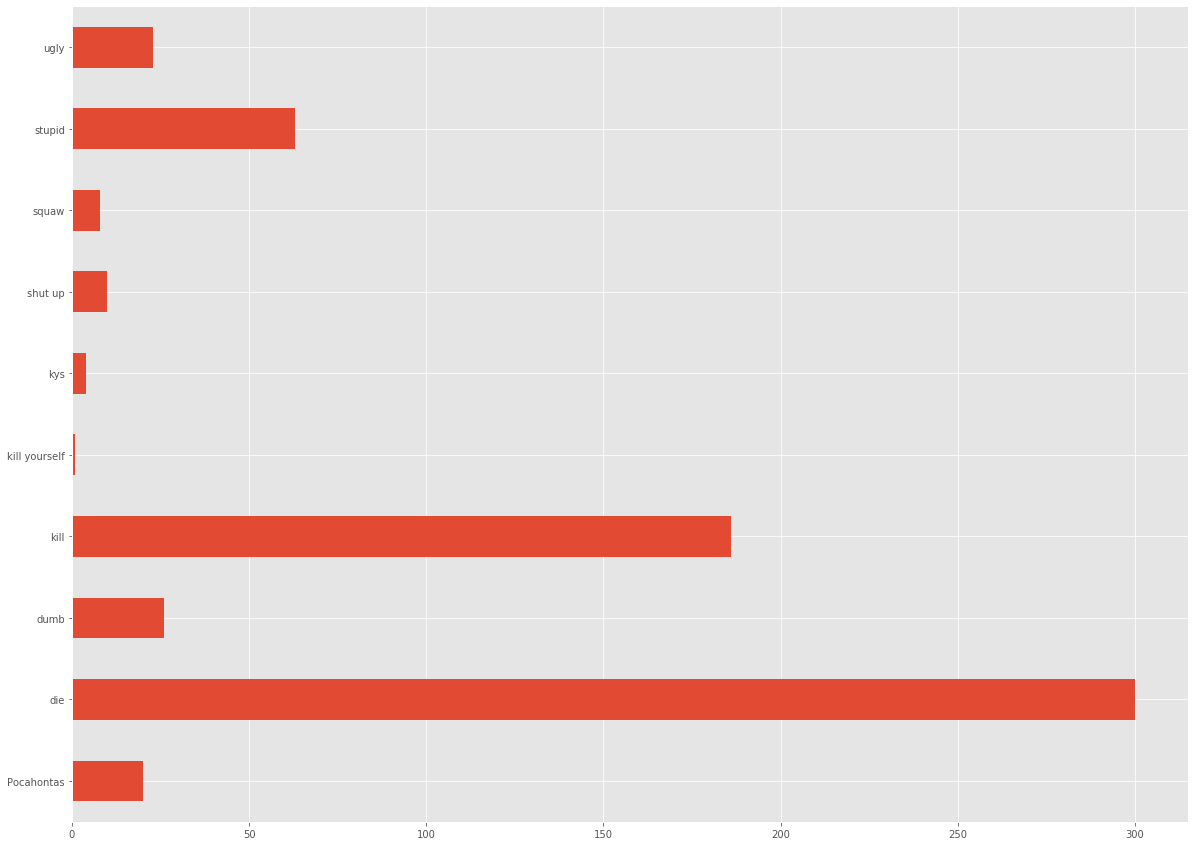

In [9]:
# visualize

terms_df_2016['term'].value_counts().sort_index().plot.barh(figsize=(20,15))

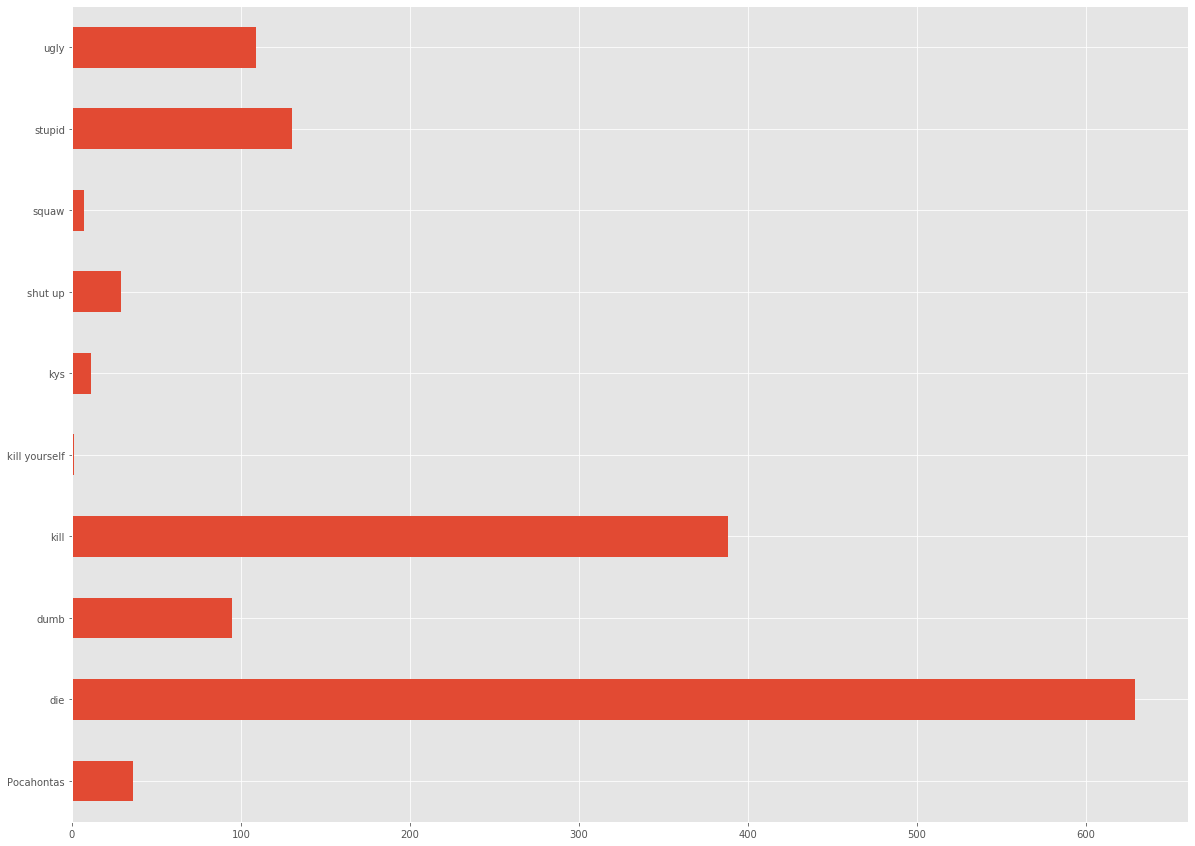

In [66]:
terms_df_2020['term'].value_counts().sort_index().plot.barh(figsize=(20,15))

Despite the fact that the 2007-2016 corpus covers more than twice the time span, initial explorations revealed a more than 40% increase in the terms tested in the 2016-2020 corpus.

Because of this, I decided to gather a larger sample focused on a shorter list of Native accounts that had notoriety for discussing tribal sovereignty, DNA testing, missing & murdered Indigenous womxn (MMIW), and/or Elizabeth Warren's claims specifically due to anecdotal reports from Natives online regarding increased harassment around Warren’s candidacy.

I also expanded the search range slightly, resetting the end date from January 28th 2020 to extend through March 6th, 2020--the day after Warren [ended her presidential campaign](https://www.cnn.com/2020/03/05/politics/elizabeth-warren-drops-out/index.html).


In [71]:
focused_list = ['DelSchilling','rebeccanagle','pollysgdaughter',
                'KimTallBear','NativeApprops','justicedanielh', 
                'PepePierce']

In [72]:
focused_list_replies_2016_to_2020_df = get_raw_dataframes(focused_list, datetime.datetime(2016,7,2), datetime.datetime(2020,3,6), 10000, include_retweets=False)


Grabbing bearer token from OAUTH


In reply to  DelSchilling dataset length:  10000 

                                                 text           author  \
0         @DelSchilling Thank you for sharing this. 💕     MiriamHavard   
1   @DelSchilling It’s a show\nwe’re all expected ...   RoseSpitznogle   
2   @DelSchilling I hope people take the time to r...  WoodwarddianneJ   
3                 @DelSchilling @BullWalksOnFire done     UweMueller68   
4   @DelSchilling 🙋🏾‍♀️ This is WHY We Wear Red an...       RoknRob121   
5   @DelSchilling I love that wth no context given...  AfroRetribution   
6   @DelSchilling @cosmyra64 Find them bring them ...        challlass   
7   @DelSchilling I will stand with you Delores. U...  RoseSta89427612   
8   @DelSchilling I really don't believe all, but ...  RoseSta89427612   
9   @DelSchilling Hippies in the 60’s figured that...         KIMPY123   
10                              @DelSchilling Exactly             L2HT   
11  @DelSchilling I realized that when I learned p...  LoveIr

Grabbing bearer token from OAUTH


In reply to  rebeccanagle dataset length:  10000 

                                                 text          author  \
0   @rebeccanagle she apologized. it was a multi-g...     deilfspirit   
1   @rebeccanagle Oh stop it with the nonsense tha...       RhunKorza   
2   @rebeccanagle Rebecca, . . #Warren came in 4th...     RidgeKayser   
3   @rebeccanagle Hi thank you for all of your ama...  bryanjoonmusic   
4               @rebeccanagle @threadreaderapp unroll      leftyvegan   
5   @rebeccanagle @JoeBiden I disagree.  Clinton w...      glennhanna   
6   @rebeccanagle @ewarren You need to be specific...      dettesgirl   
7   @rebeccanagle Alabama would have never gotten ...  Rightturn_only   
8   @rebeccanagle @JoeBiden If Trump wins you won’...     SanityFair_   
9   @rebeccanagle It was and remains an act of whi...  GothamGirlBlue   
10  @rebeccanagle @ewarren Have you been specific ...  PeaceMaker2019   
11  @rebeccanagle @JoeBiden I was in the county co...        kaltsasa   


Grabbing bearer token from OAUTH


In reply to  pollysgdaughter dataset length:  2935 

                                                 text           author  \
0   @ApacheCarolina @RachelRGonzalez He joined the...  pollysgdaughter   
1   @pollysgdaughter I’m proud to say I listened t...   RoseIsRational   
2   @pollysgdaughter @RachelRGonzalez I mean...I a...   ApacheCarolina   
3   @pollysgdaughter You were right on calling War...    PoliticalFido   
4   @pollysgdaughter @RachelRGonzalez Who is targe...   ApacheCarolina   
5   @pollysgdaughter @Amanda_Clinton @emilycheath ...     MissDawn2you   
6   @pollysgdaughter @OrganizingPower It's been ro...    RobinDuehring   
7   @pollysgdaughter I'm always forgiving to those...    WahidSakaKhan   
8               @pollysgdaughter Same. And thank you!    AndreaLRogers   
9   @pollysgdaughter @ABecenti It's not the only r...  n8vconservative   
10    @pollysgdaughter Best news I heard all day !!!!  DouglasBuchholz   
11  @pollysgdaughter @ApacheCarolina She was re-el...      

Grabbing bearer token from OAUTH


In reply to  KimTallBear dataset length:  6384 

                                                 text          author  \
0   @KimTallBear @estarianne Good point, I second ...   Theophania333   
1                @KimTallBear If you can’t win, cheat    plaidjohanna   
2         @KimTallBear @threadreaderapp unroll please    dochopehappy   
3   @KimTallBear It's why we are in the place we a...    jeannebarr54   
4                      @KimTallBear We’re here for it   carolineyezer   
5   @KimTallBear Interesting because it seems even...    symbolic_doc   
6   environmental degradation, stealing and incarc...     KimTallBear   
7      @KimTallBear and to the stock market...\n\netc    Kipperwacker   
8   @KimTallBear @gindaanis Okay, yet one more boo...  justicedanielh   
9   @KimTallBear Reading it 11 years later, during...       gindaanis   
10      @KimTallBear Please! I’ll dhare the analysis!    BrendisTrejo   
11  @KimTallBear Productivity as a driver of human...      estarianne   
12

Grabbing bearer token from OAUTH


In reply to  NativeApprops dataset length:  10000 

                                                 text           author  \
0   @NativeApprops This is my top choice when peop...       SleepyTiff   
1   I highly recommend Beth’s book! It’s beautiful...    NativeApprops   
2   @NativeApprops Before I met my wife, who is in...   Stolfidobranch   
3   @NativeApprops Feel better. I'm amazed too esp...  CarmelinaSpeaks   
4   @NativeApprops I've had 2 periods of intense s...  CarmelinaSpeaks   
5   @NativeApprops @kaniehtiio @CoffeeWithMyMa To ...     dumont_cliff   
6   @NativeApprops Lots of garlic and some chilies...      BishopNaomi   
7   @NativeApprops Fruits and veggies. Lots of ber...        jourdanbb   
8   @NativeApprops This isn’t indigenous knowledge...       ndngenuity   
9                          @NativeApprops Sent you dm        gindaanis   
10                          @NativeApprops Thank you.    1devilishgrin   
11  @NativeApprops @theoriginalmel, @Terrilltf, @j...    1de

Grabbing bearer token from OAUTH


In reply to  justicedanielh dataset length:  10000 

                                                 text          author  \
0                  @justicedanielh Ding!* Nailed it.🙃     Kerryoscity   
1   Doesn’t mean that there aren’t other valid and...  justicedanielh   
2   And it’s not like the English names are being ...  justicedanielh   
3   @justicedanielh @JuneScudeler “But residents o...    elainecorden   
4   @justicedanielh I wonder what Vancouver would ...  story_magician   
5   The settler pearl-clutching about “not being c...  justicedanielh   
6   @justicedanielh A frightful hobgoblins stalks ...    GiffordJames   
7   @justicedanielh My grandmother was adopted out...     ScoobieLady   
8   It's also how we can ensure accountability on ...  justicedanielh   
9   It's what we mean when we say it's not just wh...  justicedanielh   
10  Okay, one more last thing: reconnection isn't ...  justicedanielh   
11  @justicedanielh @BillyArmagh Yes, thank you, D...    RobynWins111  

Grabbing bearer token from OAUTH


In reply to  PepePierce dataset length:  3315 

                                                 text           author  \
0   @PepePierce Despite my Grandma being Mi'kmaq, ...  PsychedelicAnC1   
1   @PepePierce @5416384751 Those tests only even ...         quayz180   
2                 @PepePierce @threadreaderapp unroll    NualphaOmegam   
3      @PepePierce It shouldn't be that hard.  Aroha.    leeannetatana   
4   @PepePierce I am so sorry challenges to your c...        DVWoollen   
5   @PepePierce “The thing is that my body has a h...      AmySommers1   
6   @PepePierce Wow those words made me cry, I hav...        kwekwayel   
7   @PepePierce I dont claim native, despite the s...         quayz180   
8             @PepePierce Thank you for sharing this!         adelka80   
9   @PepePierce This is the one issue that i reali...         adelka80   
10  @PepePierce I don’t know who’s questioning you...        keddiejoh   
11  @PepePierce I believe she genuinely thought as...        ked

In [73]:
focused_list_replies_2016_to_2020_df = focused_list_replies_2016_to_2020_df.dropna()

print(len(focused_list_replies_2016_to_2020_df))

52634


In [74]:
focused_list_replies_2016_to_2020_df.to_csv('focused_list_replies_2016_to_2020_df.csv')

In [75]:
focused_list_terms_df = get_full_terms_df(focused_list_replies_2016_to_2020_df, term_list)

In [76]:
focused_list_terms_df = focused_list_terms_df.dropna()

print(len(focused_list_terms_df))

1999


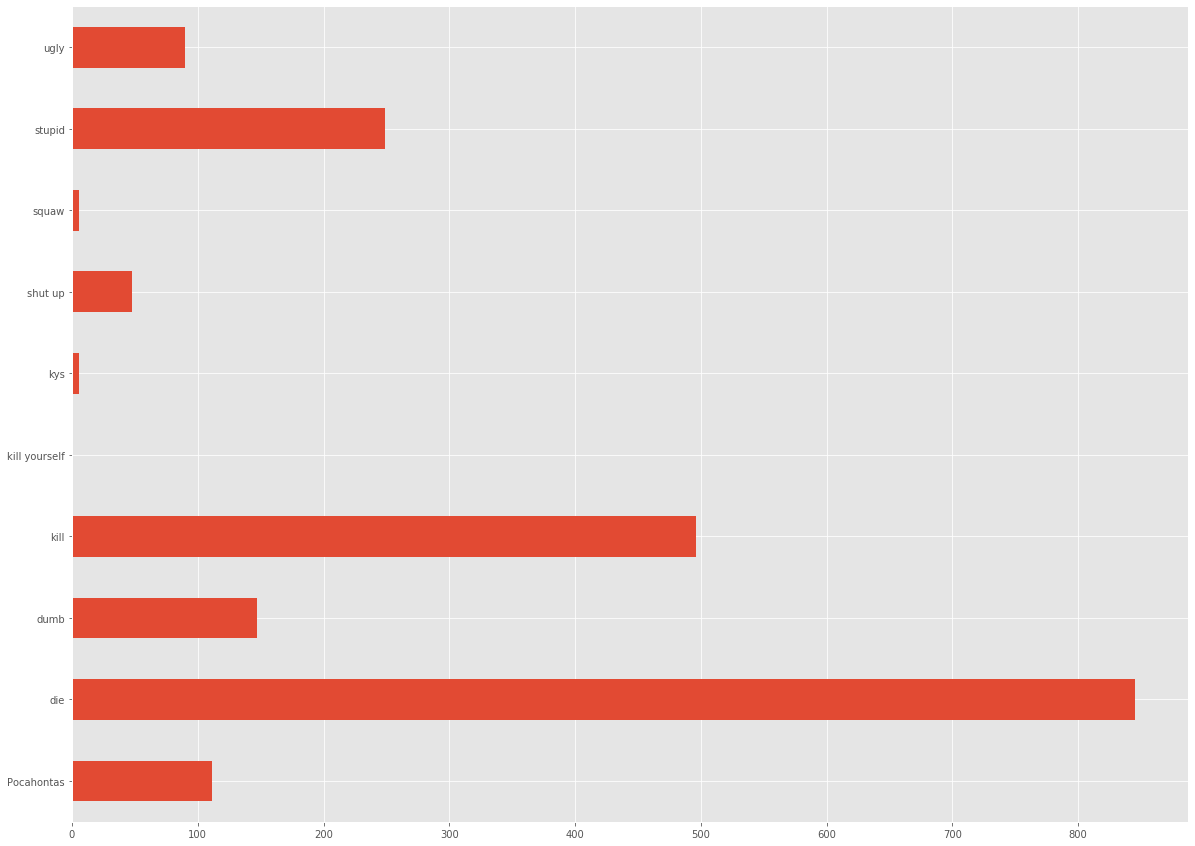

In [77]:
# visualize

focused_list_terms_df['term'].value_counts().sort_index().plot.barh(figsize=(20,15))

#### Sentiment Analysis

Searching for particular words & phrases is an intuitive approach to seeing what sentiments are present in the data. While it can be illuminating, scaling this type of analysis in certain situations can prove difficult (or at the very least, ineffective). 

Another tool foor understanding unstructured text data is sentiment analysis, where a model is trained to recognize whether the emotions expressed in a particular document are generally positive, or negative. For this task I chose to use a Naive Bayes Classifier. Bayesian classifiers (and specifically the Native Bayes model) have proven to be both simple & powerful for a variety of text classification applications.

#### Training the Classifier

There are a number of corpora that are labeled for sentiment, as well as pretrained sentiment classifiers. For this project I chose to use to Natural Language Toolkit (NLTK) `twitter_samples` set to train my model. NLTK is free and widely available, and using a dataset of tweets to train a model for classifying twitter data made intuitive sense.


In [3]:
pos_set = twitter_samples.strings('positive_tweets.json')

neg_set = twitter_samples.strings('negative_tweets.json')

#### Text Processing

In addition to cleaning the text & removing very common, low-value words like stopwords, I also _normalized_ the text using _lemmatization_. Lemmatization is a process of algorithmically applying morphological analysis to the structure of words in order to determine the most basic & meaningful form. While lemmatization is a slower normalization method, it can yield very good results.

In [62]:
# tokenize

pos_tokens = twitter_samples.tokenized('positive_tweets.json')

neg_tokens = twitter_samples.tokenized('negative_tweets.json')

In [63]:
# test

print(pos_tokens[0])

print('\n')

print(pos_tag(pos_tokens[0]))

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


[('#FollowFriday', 'JJ'), ('@France_Inte', 'NNP'), ('@PKuchly57', 'NNP'), ('@Milipol_Paris', 'NNP'), ('for', 'IN'), ('being', 'VBG'), ('top', 'JJ'), ('engaged', 'VBN'), ('members', 'NNS'), ('in', 'IN'), ('my', 'PRP$'), ('community', 'NN'), ('this', 'DT'), ('week', 'NN'), (':)', 'NN')]


In [64]:
def lemmatize_doc(tokens):
    
    '''
    takes input list of tokens
    
    returns lemmatized list
    
    '''
    
    lemmatizer = WordNetLemmatizer()
    
    lemmatized_doc = []
    
    # part-of-speech tagging algorithm
    
    for token, tag in pos_tag(tokens):
        
        # finding nouns
        
        if tag.startswith('NN'):
            
            POS = 'n'
            
        # finding verbs
        
        elif tag.startswith('VB'):
            
            POS = 'v'
            
        # finding adjectives
        
        else:
            
            POS = 'a'
            
        # call lemmatizer
        # add lemmatized doc to list  
        
        lemmatized_doc.append(lemmatizer.lemmatize(token, POS))
        
    return lemmatized_doc


In [65]:
# test on first tweet

lemmatized = lemmatize_doc(pos_tokens[0])

print(lemmatized)

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'be', 'top', 'engage', 'member', 'in', 'my', 'community', 'this', 'week', ':)']


In [124]:
def clean_tweets(doc):
    
    '''
    
    takes input doc
    
    returns list of clean tokens
    
    '''
    
    # leaving punctuation in to preserve emoticons

    # remove twitter artifacts 
    
    cleaner_tokens = [word.lower() for word in doc
                     if 'http' not in word
                     and '@' not in word
                     and '<' not in word
                     and 'RT' not in word
                     and 'amp' not in word
                     ]
    
    # remove stopwords
    
    clean_tokens = [t for t in cleaner_tokens if t.lower() not in stopwords.words('english')]
    
    return clean_tokens

In [111]:
# test

print(clean_tweets(pos_tokens[0]))

['#followfriday', 'top', 'engaged', 'members', 'community', 'week', ':)']


In [112]:
def prepare_tweets(tweet_tokens):
    
    cleaned_tokens = clean_tweets(tweet_tokens)
    
    lemmatized_tokens = tuple(lemmatize_doc(cleaned_tokens))
    
    return lemmatized_tokens

In [113]:
# test

print(prepare_tweets(pos_tokens[0]))

('#followfriday', 'top', 'engaged', 'member', 'community', 'week', ':)')


In [114]:
# apply text prep to entire dataset

pos_clean_tokens = []

neg_clean_tokens = []

for tokens in pos_tokens:
    
    pos_clean_tokens.append(prepare_tweets(tokens))
    
for tokens in neg_tokens:
    
    neg_clean_tokens.append(prepare_tweets(tokens))
       

In [115]:
print(pos_clean_tokens)

[('#followfriday', 'top', 'engaged', 'member', 'community', 'week', ':)'), ('hey', 'james', '!', 'odd', ':/', 'please', 'call', 'contact', 'centre', '02392441234', 'able', 'assist', ':)', 'many', 'thanks', '!'), ('listen', 'last', 'night', ':)', 'bleed', 'amazing', 'track', '.', 'scotland', '?', '!'), ('congrats', ':)'), ('yeaaaah', 'yippppy', '!', '!', '!', 'accnt', 'verify', 'rqst', 'succeed', 'get', 'blue', 'tick', 'mark', 'fb', 'profile', ':)', '15', 'day'), ('one', 'irresistible', ':)', '#flipkartfashionfriday'), ('like', 'keep', 'lovely', 'customer', 'wait', 'long', '!', 'hope', 'enjoy', '!', 'happy', 'friday', '!', '-', 'lwwf', ':)'), ('second', 'thought', ',', '’', 'enough', 'time', 'dd', ':)', 'new', 'short', 'enter', 'system', '.', 'sheep', 'must', 'buy', '.'), ('jgh', ',', 'go', 'bayan', ':d', 'bye'), ('act', 'mischievousness', ',', 'call', 'etl', 'layer', 'in-house', 'warehouse', 'app', 'katamari', '.', 'well', '…', 'name', 'implies', ':p', '.'), ('#followfriday', 'top', 'i

In [116]:
pos_freq = FreqDist(pos_clean_tokens)

print(pos_freq.most_common(10))

[(('follow', '&', 'follow', 'u', 'back', ':)'), 62), (('stats', 'day', 'arrive', '.', '1', 'new', 'follower', 'unfollowers', ':)', 'via', '.'), 31), (('fback', '?', ':)'), 25), (('thank', ':)'), 21), (('hello', ':)', 'get', 'youth', 'job', 'opportunity', 'follow', '>', '>'), 19), (('thanks', ':)'), 19), (('hi', '!', 'would', 'like', 'concert', '?', 'let', 'know', 'city', 'country', "i'll", 'start', 'work', '!', 'thanks', ':)'), 17), (('stats', 'week', 'arrive', '.', '1', 'new', 'follower', 'unfollowers', ':)', 'via', '.'), 13), (('visit', 'blog', 'thanks', ':d'), 12), (('welcome', ':)'), 11)]


In [117]:
def prep_tweets_for_model(clean_words):
    
    # create dictionary for NLTK model
    
    for words in clean_words:
        
        yield dict([word, True] for word in words)


In [118]:
pos_words_model_ready = prep_tweets_for_model(pos_clean_tokens)

neg_words_model_ready = prep_tweets_for_model(neg_clean_tokens)

In [119]:
print(pos_words_model_ready)

<generator object prep_tweets_for_model at 0x7fe24a9c7780>


#### Creating a Labeled Dataset and Train Test Split

In [120]:
# create labeled positive & negative datasets

pos_dataset = [(dictionary, 'Positive') for dictionary in pos_words_model_ready]

neg_dataset = [(dictionary, 'Negative') for dictionary in neg_words_model_ready]

full_dataset = pos_dataset + neg_dataset

# shuffle examples to reduce bias

random.shuffle(full_dataset)

# 70/30 train test split

training_data = full_dataset[:7000]

test_data = full_dataset[7000:]


#### Training the NLTK Naive Bayes Classifier 

In [121]:
NB_classifier = NaiveBayesClassifier.train(training_data)

In [122]:
print('model accuracy: ', classify.accuracy(NB_classifier, test_data))

model accuracy:  0.996


In [123]:
print(NB_classifier.show_most_informative_features(20))

Most Informative Features
                      :) = True           Positi : Negati =    999.5 : 1.0
                follower = True           Positi : Negati =     42.9 : 1.0
                     sad = True           Negati : Positi =     26.8 : 1.0
                    sick = True           Negati : Positi =     20.4 : 1.0
                     x15 = True           Negati : Positi =     17.1 : 1.0
               community = True           Positi : Negati =     16.1 : 1.0
              appreciate = True           Positi : Negati =     16.1 : 1.0
                  arrive = True           Positi : Negati =     15.5 : 1.0
                    blog = True           Positi : Negati =     13.4 : 1.0
                    tire = True           Negati : Positi =     13.0 : 1.0
                  excite = True           Positi : Negati =     12.7 : 1.0
               goodnight = True           Positi : Negati =     12.7 : 1.0
                    damn = True           Negati : Positi =     12.6 : 1.0

#### Custom Text Processing Pipeline for Bespoke Corpora

In [128]:
# load DataFrames

raw_replies_2016_df = pd.read_csv('raw_replies_2007_to_2016.csv')

raw_replies_2020_df = pd.read_csv('raw_replies_2016_to_2020_full.csv')

focused_list_replies_2016_to_2020_df = pd.read_csv('focused_list_replies_2016_to_2020_df.csv')

In [132]:
# create DFs with containing text of tweets

raw_replies_2016_TXT = raw_replies_2016_df['text']

raw_replies_2020_TXT = raw_replies_2020_df['text']

focused_list_replies_2020_TXT = focused_list_replies_2016_to_2020_df['text']

print(raw_replies_2016_TXT.head())

0                          @Pandabbadon goddamnit! No!
1    @Pandabbadon there's a lot of tweets in my tim...
2    @Pandabbadon Dephine? Have we found out what h...
3                      @Pandabbadon did they kill her?
4    @Pandabbadon it's Pet Smart! I used to work th...
Name: text, dtype: object


In [151]:
test_tweet = raw_replies_2016_TXT[0]

print(test_tweet)

@Pandabbadon goddamnit! No!


In [152]:
test_tokens = prepare_tweets(word_tokenize(test_tweet))

print(NB_classifier.classify(dict([token, True] for token in test_tokens)))

Positive


In [157]:
results = []

random.shuffle(raw_replies_2016_TXT)

for doc in raw_replies_2016_TXT:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    results.append(NB_classifier.classify(dict([token, True] for token in tokens)))
    

In [158]:
print(len(raw_replies_2016_TXT))

print(len(results))

30658
30658


In [159]:
num_pos_2016 = [i for i in results if i == 'Positive']

print(len(num_pos_2016))

19360


In [163]:
results_2 = []

random.shuffle(raw_replies_2020_TXT)

for doc in raw_replies_2020_TXT:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    results_2.append(NB_classifier.classify(dict([token, True] for token in tokens)))

num_pos_2020 = [i for i in results_2 if i == 'Positive']

print('total dataset length: ', len(raw_replies_2020_TXT))

print('num of positive tweets: ', len(num_pos_2020))

total dataset length:  49391
num of positive tweets:  28270


In [164]:
results_3 = []

random.shuffle(focused_list_replies_2020_TXT)

for doc in focused_list_replies_2020_TXT:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    results_3.append(NB_classifier.classify(dict([token, True] for token in tokens)))

num_pos_focused_list = [i for i in results_3 if i == 'Positive']

print('total dataset length: ', len(focused_list_replies_2020_TXT))

print('num of positive tweets: ', len(num_pos_focused_list))

total dataset length:  52634
num of positive tweets:  31347


In [165]:
focused_list_replies_2016_to_2020_df.head()

,Unnamed: 0,text,author,replying_to
0,0,@KimTallBear As someone who has a family oral ...,MiriamHavard,DelSchilling
1,1,@PepePierce Amen. While I cannot know your pai...,RoseSpitznogle,DelSchilling
2,2,@NativeApprops Ooooh these are all great news!...,WoodwarddianneJ,DelSchilling
3,3,"As a Native woman, every time I see ""Pocahonta...",UweMueller68,DelSchilling
4,4,@NativeApprops What ever happened to the best ...,RoknRob121,DelSchilling


In [221]:
# focused_list = ['DelSchilling','rebeccanagle','pollysgdaughter',
#                'KimTallBear','NativeApprops','justicedanielh', 
#                'PepePierce']

# focused_list_replies_2016_to_2020_df


def make_indv_df(name):
    
    '''
    
    creates a DataFrame of replies for each individual account on focused_list
    
    '''
    
    indv_df = pd.DataFrame()
    
    indv_df = focused_list_replies_2016_to_2020_df[focused_list_replies_2016_to_2020_df['replying_to'] == name]
    
    indv_df = indv_df['text']
    
    return indv_df


In [174]:
# grab individual DFs

DelSchilling_text_df = make_indv_df('DelSchilling')

rebeccanagle_text_df = make_indv_df('rebeccanagle')

pollysgdaughter_text_df = make_indv_df('pollysgdaughter')

KimTallBear_text_df = make_indv_df('KimTallBear')

NativeApprops_text_df = make_indv_df('NativeApprops')

justicedanielh_text_df = make_indv_df('justicedanielh')

PepePierce_text_df = make_indv_df('PepePierce')

In [177]:
DelSchilling_results = []

for doc in DelSchilling_text_df:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    DelSchilling_results.append(NB_classifier.classify(dict([token, True] for token in tokens)))

    num_pos = [i for i in DelSchilling_results if i == 'Positive']

print('total dataset length: ', len(DelSchilling_text_df))

print('num of positive tweets: ', len(num_pos))

total dataset length:  10000
num of positive tweets:  5975


In [182]:
rebeccanagle_results = []

for doc in rebeccanagle_text_df:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    rebeccanagle_results.append(NB_classifier.classify(dict([token, True] for token in tokens)))

    num_pos = [i for i in rebeccanagle_results if i == 'Positive']

print('total dataset length: ', len(rebeccanagle_text_df))

print('num of positive tweets: ', len(num_pos))

total dataset length:  10000
num of positive tweets:  5947


In [183]:
pollysgdaughter_results = []

for doc in pollysgdaughter_text_df:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    pollysgdaughter_results.append(NB_classifier.classify(dict([token, True] for token in tokens)))

    num_pos = [i for i in pollysgdaughter_results if i == 'Positive']

print('total dataset length: ', len(pollysgdaughter_text_df))

print('num of positive tweets: ', len(num_pos))

total dataset length:  2935
num of positive tweets:  1714


In [184]:
KimTallBear_results = []

for doc in KimTallBear_text_df:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    KimTallBear_results.append(NB_classifier.classify(dict([token, True] for token in tokens)))

    num_pos = [i for i in KimTallBear_results if i == 'Positive']

print('total dataset length: ', len(KimTallBear_text_df))

print('num of positive tweets: ', len(num_pos))

total dataset length:  6384
num of positive tweets:  3759


In [185]:
NativeApprops_results = []

for doc in NativeApprops_text_df:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    NativeApprops_results.append(NB_classifier.classify(dict([token, True] for token in tokens)))

    num_pos = [i for i in NativeApprops_results if i == 'Positive']

print('total dataset length: ', len(NativeApprops_text_df))

print('num of positive tweets: ', len(num_pos))

total dataset length:  10000
num of positive tweets:  6016


In [186]:
justicedanielh_results = []

for doc in justicedanielh_text_df:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    justicedanielh_results.append(NB_classifier.classify(dict([token, True] for token in tokens)))

    num_pos = [i for i in justicedanielh_results if i == 'Positive']

print('total dataset length: ', len(justicedanielh_text_df))

print('num of positive tweets: ', len(num_pos))

total dataset length:  10000
num of positive tweets:  5955


In [187]:
PepePierce_results = []

for doc in PepePierce_text_df:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    PepePierce_results.append(NB_classifier.classify(dict([token, True] for token in tokens)))

    num_pos = [i for i in PepePierce_results if i == 'Positive']

print('total dataset length: ', len(PepePierce_text_df))

print('num of positive tweets: ', len(num_pos))

total dataset length:  3315
num of positive tweets:  1981


In [223]:
def make_indv_replies2020_df(name):
    
    '''
    
    creates a DataFrame of replies for each individual account on raw_replies_2020_df
    
    '''
    
    indv_df = pd.DataFrame()
    
    indv_df = raw_replies_2020_df[raw_replies_2020_df['replying_to'] == name]
    
    indv_df = indv_df['text']
    
    return indv_df



In [225]:
# get individual DFs with tweet text
# accounts: AwkwardRambler, AngryBlackN8V, Pandabbadon, AzieDee 

AwkwardRambler_text_df = make_indv_replies2020_df('AwkwardRambler')

AngryBlackN8V_text_df = make_indv_replies2020_df('AngryBlackN8V')

Pandabbadon_text_df = make_indv_replies2020_df('Pandabbadon')

AzieDee_text_df = make_indv_replies2020_df('AzieDee')

In [226]:
AwkwardRambler_results = []

for doc in AwkwardRambler_text_df:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    AwkwardRambler_results.append(NB_classifier.classify(dict([token, True] for token in tokens)))

    num_pos = [i for i in AwkwardRambler_results if i == 'Positive']

print('total dataset length: ', len(AwkwardRambler_text_df))

print('num of positive tweets: ', len(num_pos))

total dataset length:  1000
num of positive tweets:  556


In [227]:
AngryBlackN8V_results = []

for doc in AngryBlackN8V_text_df:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    AngryBlackN8V_results.append(NB_classifier.classify(dict([token, True] for token in tokens)))

    num_pos = [i for i in AngryBlackN8V_results if i == 'Positive']

print('total dataset length: ', len(AngryBlackN8V_text_df))

print('num of positive tweets: ', len(num_pos))

total dataset length:  866
num of positive tweets:  509


In [228]:
Pandabbadon_results = []

for doc in Pandabbadon_text_df:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    Pandabbadon_results.append(NB_classifier.classify(dict([token, True] for token in tokens)))

    num_pos = [i for i in Pandabbadon_results if i == 'Positive']

print('total dataset length: ', len(Pandabbadon_text_df))

print('num of positive tweets: ', len(num_pos))

total dataset length:  1000
num of positive tweets:  588


In [232]:
AzieDee_results = []

for doc in AzieDee_text_df:
    
    tokens = prepare_tweets(word_tokenize(doc))
    
    AzieDee_results.append(NB_classifier.classify(dict([token, True] for token in tokens)))

    num_pos = [i for i in AzieDee_results if i == 'Positive']

print('total dataset length: ', len(AzieDee_text_df))

print('num of positive tweets: ', len(num_pos))

total dataset length:  1000
num of positive tweets:  546


In [141]:
# accounts, followers & num of positives:

# 1) AngryBlackN8, 2,076, 509/866
# 2) Pandabbadon, 2,395, 588/1000
# 3) AwkwardRambler, 4,575, 556/1000
# 4) AzieDee, 9,197, 546/1000

accts = ['Account 1','Account 2', 
         'Account 3','Account 4']

positives = [59.46, 58.8, 55.6, 54.6]

negative_replies = [41.22, 41.2, 44.4, 45.4]

followers = [2076, 2395, 4575, 9197]

df = pd.DataFrame(list(zip(accts, positives, negative_replies, followers)), columns=['account','positives','negative replies','followers'])

df.head()

,account,positives,negative replies,followers
0,Account 1,59.46,41.22,2076
1,Account 2,58.80,41.20,2395
2,Account 3,55.60,44.40,4575
3,Account 4,54.60,45.40,9197


### Visualizing the Data

#### Black Native Accounts

As Black Native accounts attract more followers, they also receive an increase in hostile responses:

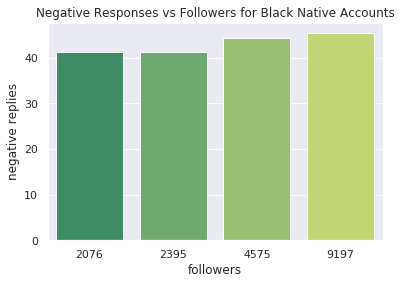

In [142]:
plt.title('Negative Responses vs Followers for Black Native Accounts')
sns.barplot(x='followers', y='negative replies', data=df, palette='summer')

In [126]:
terms_df_2020['date'] = 'July 2016 - 2020'

terms_df_2016['date'] = '2006 - July 2016'

terms_2016_2020 = terms_df_2016.append(terms_df_2020)

print(len(terms_df_2016))

print(len(terms_df_2020))

print(len(terms_2016_2020))

641
1435
2076


#### Hateful & Hostile Terms

There has been a marked increase in hateful & anti-Indigenous terms, as well as references to death & suicide, since the 2016 election cycle:

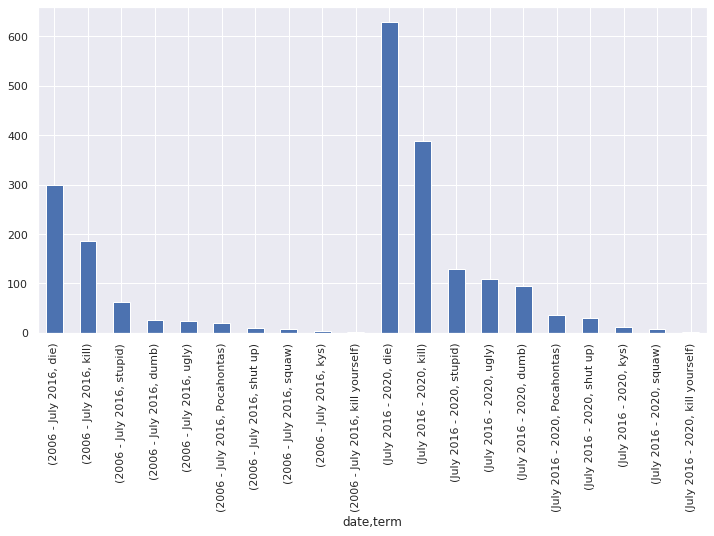

In [134]:
terms_2016_2020.groupby("date").term.value_counts().plot.bar(figsize=(12,6))

In [143]:
dates = ['2006 - July 2016', 'July 2016 - 2020']

negative_responses = [36.86, 42.77]

df_dates = pd.DataFrame(list(zip(dates, negative_responses)), columns=['dates','negative responses'])

df_dates.head()

,dates,negative responses
0,2006 - July 2016,36.86
1,July 2016 - 2020,42.77


#### Increase in Negative Sentiment

Negative sentiment in replies towards Natives has increased measurably since the 2016 election cycle:

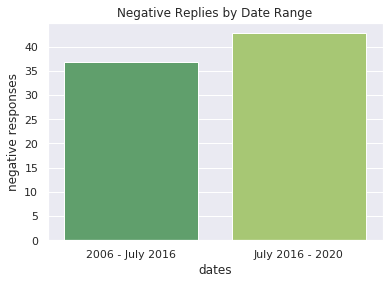

In [144]:
plt.title('Negative Replies by Date Range')
sns.barplot(x='dates', y='negative responses', data=df_dates, palette='summer')